In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import ast

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import geopy.distance
from scipy import stats
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Для распечатки в цвете
from termcolor import colored

import nltk
from nltk.tokenize import word_tokenize

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# 0. ПОСТАНОВКА ПРОБЛЕМЫ

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. СБОР ДАННЫХ

In [4]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# Объединяем данные с помощью метода concat
data = pd.concat([df_test, df_train], ignore_index=True, sort=False)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. ОЧИСТКА ДАННЫХ

Поиск пропусков и заполнение данными 


## 2.1. Поиск дубликатов и их удаление 

In [11]:
dupl_columns = list(data.columns)

mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

data_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data_dedupped.shape[0]}')

Число найденных дубликатов: 336
Результирующее число записей: 515402


## 2.2. Обработка пропущенных значений 



In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Видно, что пропуски у двух признаков lng и lag - это коорднинаты местоположения гостиницы

In [13]:
data['hotel_city'] = data['hotel_address'].apply\
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [14]:
data2 = data.copy()

City_bins = data2.groupby(['hotel_city'])

# найдем медианные координаты с учетом получившихся групп
median_lat = City_bins.lat.median()
median_lng = City_bins.lng.median()

# Применим lambda-функцию к объекту SeriesGroupBy и заменим пропуски соответствующим медианным значением.
data2['lat'] = City_bins.lat.transform(lambda x: x.fillna(x.median()))
data2['lng'] = City_bins.lng.transform(lambda x: x.fillna(x.median()))

data = data2

In [15]:
def calculate_average_review_score(data):
    # Создаем словарь для хранения средних значений по каждой гостинице
    average_review_scores = {}
    
    # Итерируемся по уникальным названиям гостиниц
    for hotel_name in data['hotel_name'].unique():
        # Выбираем только строки для конкретной гостиницы
        mask = data[data['hotel_name'] == hotel_name]
        # Вычисляем среднее значение между 'average_score' и 'reviewer_score' для гостиницы
        average_score = mask[['average_score', 'reviewer_score']].mean().mean()
        # Сохраняем среднее значение в словаре
        average_review_scores[hotel_name] = average_score
    
    # Добавляем новый столбец 'average_review_score' в основной DataFrame 'data'
    data['average_review_score'] = data['hotel_name'].map(average_review_scores)

# Применяем функцию к основному DataFrame 'data'
calculate_average_review_score(data)


## 2.3. Методы выявления выбросов



#### Пробовал сначала пройтись через метод Тьюки, и с ним получаеться победить выбросы, но когда учу модель измененные признаки становяться не актуальны для модели.

##### Поэтому использую не нормализацию, а стандартизацию признаков и заодно кодирую признаки типа 'object', после изучение модели, данный метод оказался вкуснее всего. 

##### Вначале я конечно же все без исключения признаки закодировал, но когда посмотрел на то, что несет ценность для модели, а что нет, сделал корректировку, поэтому вы можете видеть не похожие по логике признаки. 

### 2.3.1. признак 'additional_number_of_scoring'

некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки

In [16]:
# Смотрю как распределены значения
data['additional_number_of_scoring'].describe()

count    515738.000000
mean        498.081836
std         500.538467
min           1.000000
25%         169.000000
50%         341.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

In [17]:
# Знакомлюсь с данными 
data['additional_number_of_scoring'].tail(10)

515728     70
515729     91
515730    545
515731    597
515732    918
515733    107
515734    272
515735    457
515736    365
515737    222
Name: additional_number_of_scoring, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


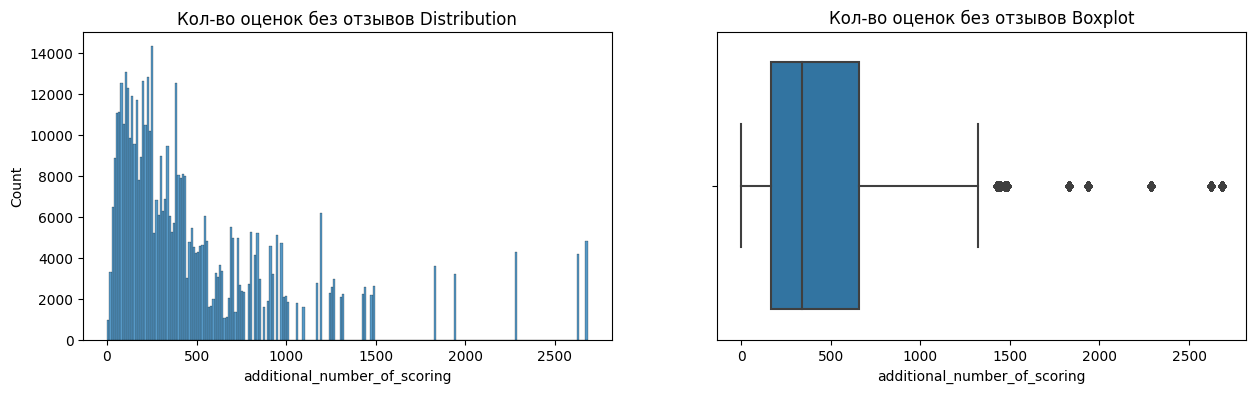

In [18]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='additional_number_of_scoring', ax=axes[0]);
histplot.set_title('Кол-во оценок без отзывов Distribution');
boxplot = sns.boxplot(data=data, x='additional_number_of_scoring', ax=axes[1]);
boxplot.set_title('Кол-во оценок без отзывов Boxplot');

In [19]:
# Инициализация стандартизатора
scaler = StandardScaler()

# Преобразование признака с помощью стандартизатора
data['standardized_additional_number_of_scoring'] = scaler.fit_transform(data[['additional_number_of_scoring']])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


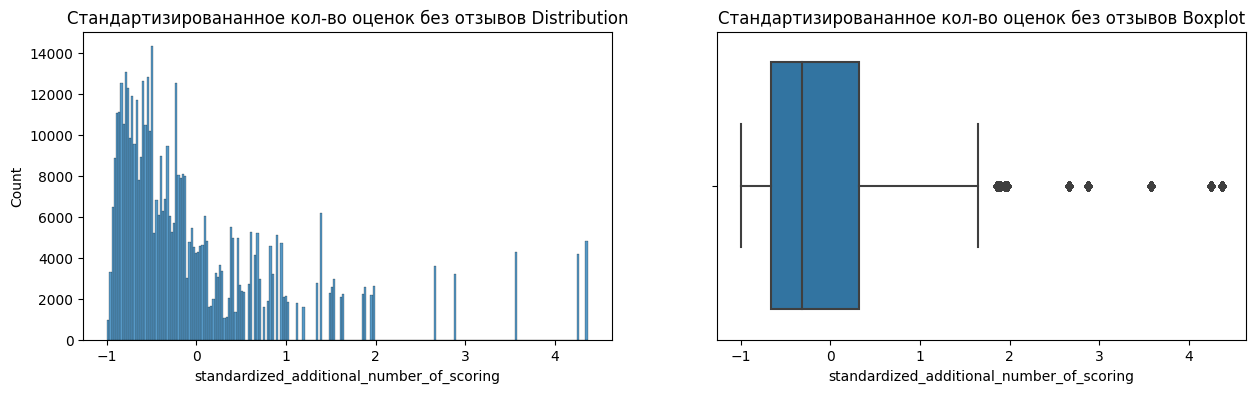

In [20]:
# Строю график и наблюдаю распределение 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='standardized_additional_number_of_scoring', ax=axes[0]);
histplot.set_title('Стандартизировананное кол-во оценок без отзывов Distribution');
boxplot = sns.boxplot(data=data, x='standardized_additional_number_of_scoring', ax=axes[1]);
boxplot.set_title('Стандартизировананное кол-во оценок без отзывов Boxplot');

In [21]:
# Наблюдаю стандаритизированные значения 
data['standardized_additional_number_of_scoring'].describe()

count    5.157380e+05
mean     1.766237e-17
std      1.000001e+00
min     -9.930951e-01
25%     -6.574563e-01
50%     -3.138260e-01
75%      3.234883e-01
max      4.363142e+00
Name: standardized_additional_number_of_scoring, dtype: float64

### 2.3.2. признак 'total_number_of_reviews'

общее количество действительных отзывов об отеле

In [22]:
# Смотрю как распределены значения
data['total_number_of_reviews'].describe()

count    515738.000000
mean       2743.743944
std        2317.464868
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

In [23]:
# Знакомлюсь с данными 
data['total_number_of_reviews'].tail(10)

515728     652
515729     564
515730    2907
515731    2308
515732    4117
515733     617
515734    3224
515735    2751
515736    1567
515737    1209
Name: total_number_of_reviews, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


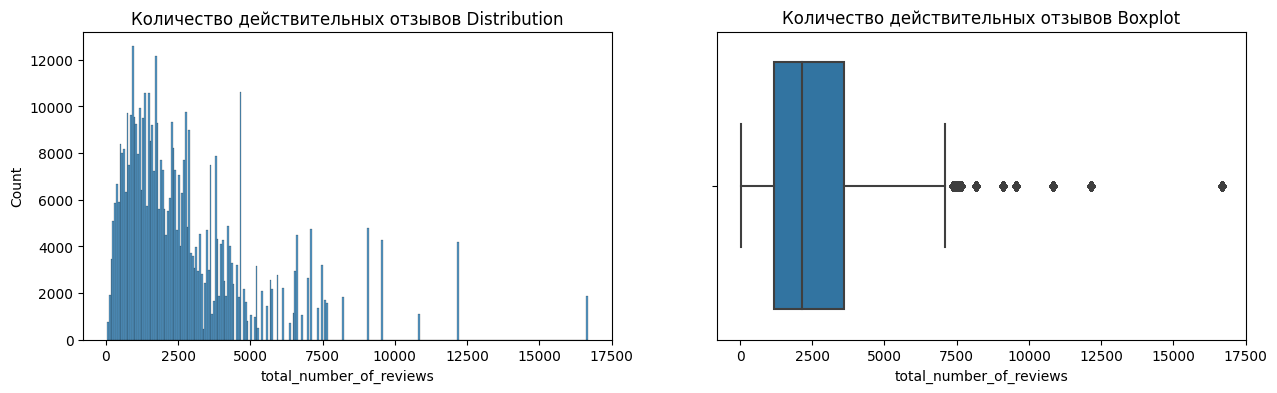

In [24]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='total_number_of_reviews', ax=axes[0]);
histplot.set_title('Количество действительных отзывов Distribution');
boxplot = sns.boxplot(data=data, x='total_number_of_reviews', ax=axes[1]);
boxplot.set_title('Количество действительных отзывов Boxplot');

In [25]:
# from sklearn.preprocessing import StandardScaler

# Инициализация стандартизатора
scaler = StandardScaler()

# Преобразование признака с помощью стандартизатора
data['standardized_total_number_of_reviews'] = scaler.fit_transform(data[['total_number_of_reviews']].values.reshape(-1, 1))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


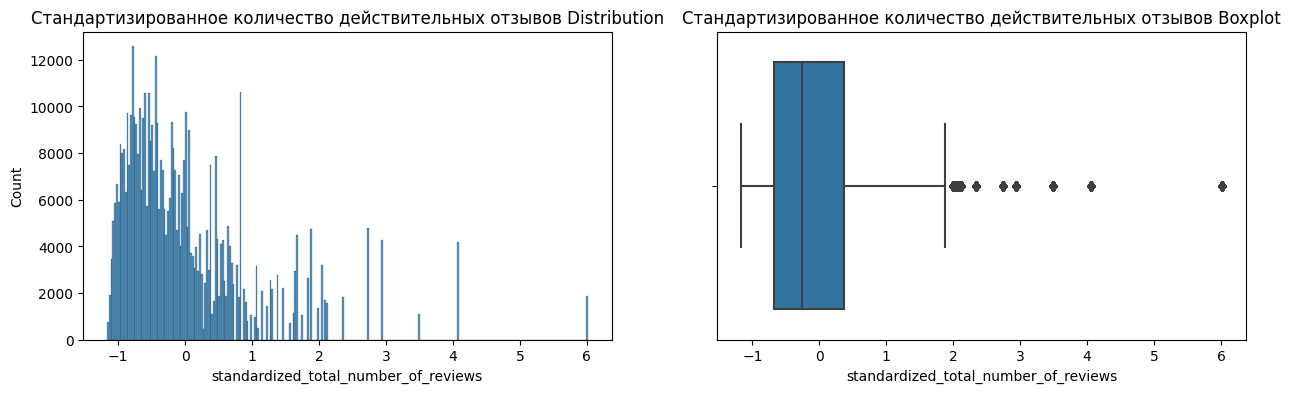

In [26]:
# Строю график и наблюдаю распределение 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='standardized_total_number_of_reviews', ax=axes[0]);
histplot.set_title('Стандартизированное количество действительных отзывов Distribution');
boxplot = sns.boxplot(data=data, x='standardized_total_number_of_reviews', ax=axes[1]);
boxplot.set_title('Стандартизированное количество действительных отзывов Boxplot');

In [27]:
# Наблюдаю стандаритизированные значения 
data['standardized_total_number_of_reviews'].describe()

count    5.157380e+05
mean    -2.594247e-17
std      1.000001e+00
min     -1.165388e+00
25%     -6.829642e-01
50%     -2.631084e-01
75%      3.750896e-01
max      6.009269e+00
Name: standardized_total_number_of_reviews, dtype: float64

### 2.3.3. признак 'review_total_negative_word_counts'

общее количество слов в отрицательном отзыве

In [28]:
# Смотрю как распределены значения
data['review_total_negative_word_counts'].describe()

count    515738.000000
mean         18.539450
std          29.690831
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

In [29]:
# Знакомлюсь с данными 
data['review_total_negative_word_counts'].tail(10)

515728     0
515729     0
515730     7
515731    30
515732    25
515733     0
515734     0
515735    12
515736     0
515737    20
Name: review_total_negative_word_counts, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


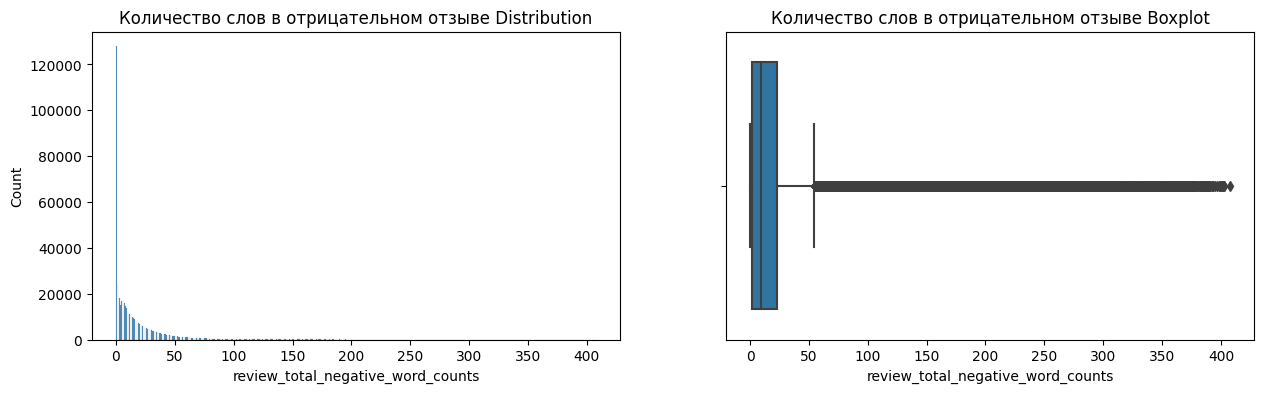

In [30]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='review_total_negative_word_counts', ax=axes[0]);
histplot.set_title('Количество слов в отрицательном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='review_total_negative_word_counts', ax=axes[1]);
boxplot.set_title('Количество слов в отрицательном отзыве Boxplot');

In [31]:
# Преобразование признака с помощью стандартизатора
data['standardized_review_total_negative_word_counts'] = scaler.fit_transform(data[['review_total_negative_word_counts']])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


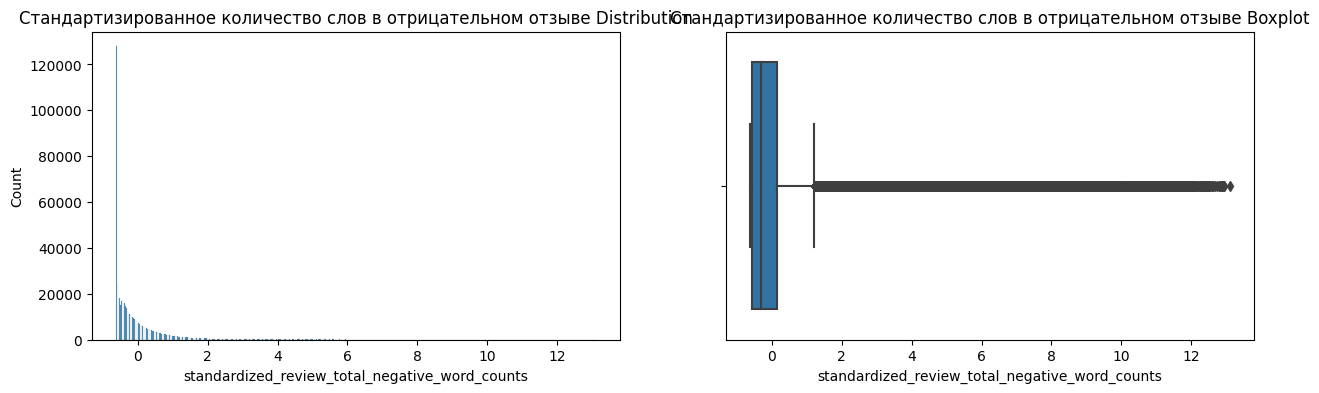

In [32]:
# Строю график и наблюдаю распределение 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='standardized_review_total_negative_word_counts', ax=axes[0]);
histplot.set_title('Стандартизированное количество слов в отрицательном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='standardized_review_total_negative_word_counts', ax=axes[1]);
boxplot.set_title('Стандартизированное количество слов в отрицательном отзыве Boxplot');

In [33]:
# Наблюдаю стандаритизированные значения 
data['standardized_review_total_negative_word_counts'].describe()

count    5.157380e+05
mean     1.895743e-17
std      1.000001e+00
min     -6.244173e-01
25%     -5.570564e-01
50%     -3.212931e-01
75%      1.502334e-01
max      1.311721e+01
Name: standardized_review_total_negative_word_counts, dtype: float64

### 2.3.4. признак 'review_total_positive_word_counts'

общее количество слов в положительном отзыве

In [34]:
# Смотрю как распределены значения
data['review_total_positive_word_counts'].describe()

count    515738.000000
mean         17.776458
std          21.804185
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

In [35]:
# Знакомлюсь с данными 
data['review_total_positive_word_counts'].tail(10)

515728     2
515729    10
515730     3
515731     6
515732    13
515733    10
515734    93
515735     9
515736     6
515737    20
Name: review_total_positive_word_counts, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


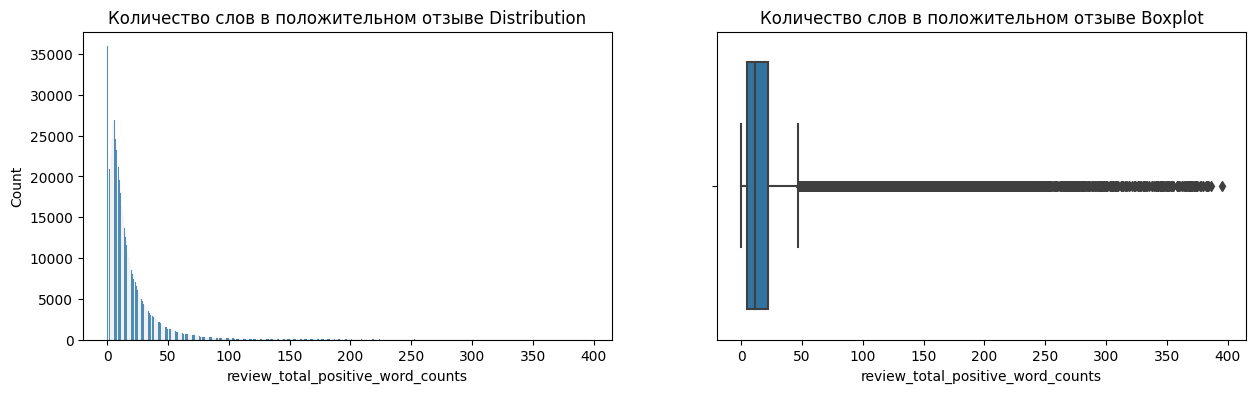

In [36]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='review_total_positive_word_counts', ax=axes[0]);
histplot.set_title('Количество слов в положительном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='review_total_positive_word_counts', ax=axes[1]);
boxplot.set_title('Количество слов в положительном отзыве Boxplot');

In [37]:
data['standardized_review_total_positive_word_counts'] = scaler.fit_transform(data[['review_total_positive_word_counts']])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


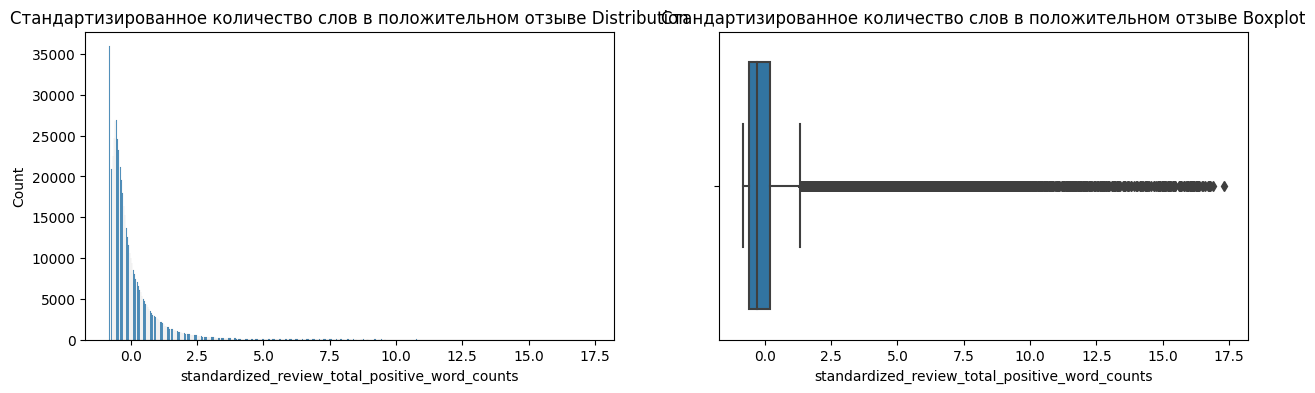

In [38]:
# Строю график и наблюдаю распределение 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='standardized_review_total_positive_word_counts', ax=axes[0]);
histplot.set_title('Стандартизированное количество слов в положительном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='standardized_review_total_positive_word_counts', ax=axes[1]);
boxplot.set_title('Стандартизированное количество слов в положительном отзыве Boxplot');

In [39]:
# Наблюдаю стандаритизированные значения 
data['standardized_review_total_positive_word_counts'].describe()

count    5.157380e+05
mean     2.849126e-17
std      1.000001e+00
min     -8.152781e-01
25%     -5.859641e-01
50%     -3.107873e-01
75%      1.937034e-01
max      1.730053e+01
Name: standardized_review_total_positive_word_counts, dtype: float64

### 2.3.5. признак 'total_number_of_reviews_reviewer_has_given'

количество отзывов, которые рецензенты дали в прошлом


In [40]:
# Смотрю как распределены значения
data['total_number_of_reviews_reviewer_has_given'].describe()

count    515738.000000
mean          7.166001
std          11.040228
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

In [41]:
# Знакомлюсь с данными 
data['total_number_of_reviews_reviewer_has_given'].tail(10)

515728     5
515729    40
515730     1
515731     3
515732     3
515733    10
515734     1
515735    21
515736    28
515737     2
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


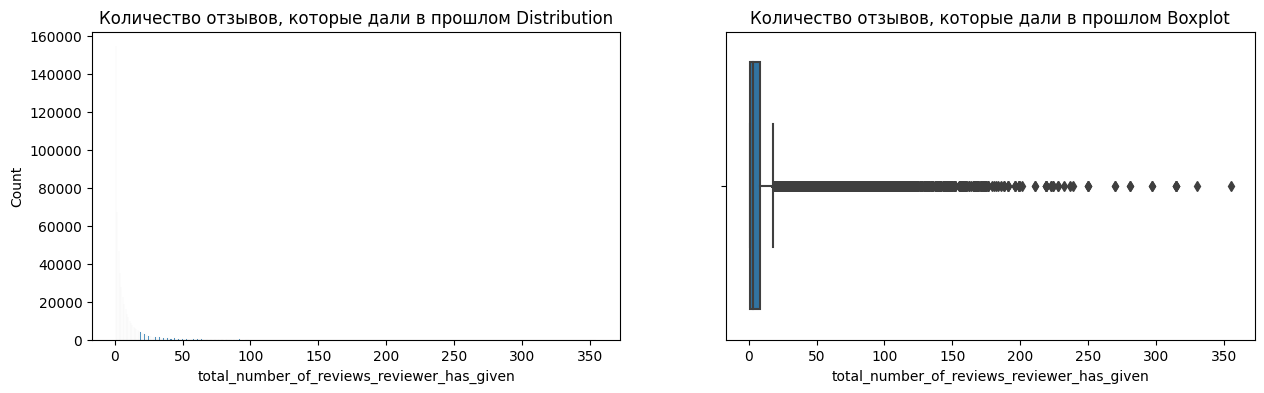

In [42]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', ax=axes[0]);
histplot.set_title('Количество отзывов, которые дали в прошлом Distribution');
boxplot = sns.boxplot(data=data, x='total_number_of_reviews_reviewer_has_given', ax=axes[1]);
boxplot.set_title('Количество отзывов, которые дали в прошлом Boxplot');

In [43]:
data['standardized_total_number_of_reviews_reviewer_has_given'] = scaler.fit_transform(data[['total_number_of_reviews_reviewer_has_given']])


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


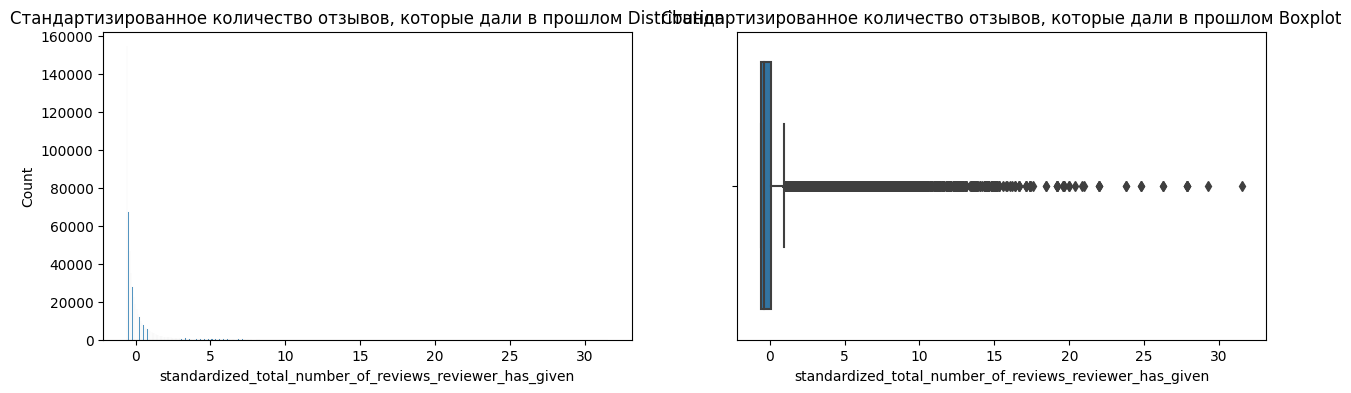

In [44]:
# Строю график и наблюдаю распределение 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='standardized_total_number_of_reviews_reviewer_has_given', ax=axes[0]);
histplot.set_title('Стандартизированное количество отзывов, которые дали в прошлом Distribution');
boxplot = sns.boxplot(data=data, x='standardized_total_number_of_reviews_reviewer_has_given', ax=axes[1]);
boxplot.set_title('Стандартизированное количество отзывов, которые дали в прошлом Boxplot');

In [45]:
# Наблюдаю стандаритизированные значения 
data['standardized_total_number_of_reviews_reviewer_has_given'].describe()

count    5.157380e+05
mean     2.652112e-17
std      1.000001e+00
min     -5.585036e-01
25%     -5.585036e-01
50%     -3.773477e-01
75%      7.554191e-02
max      3.150608e+01
Name: standardized_total_number_of_reviews_reviewer_has_given, dtype: float64

# 3. РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ

## 3.1. Создание новых признаков 


### 3.1.1. Признак 'negative_review'

#### Создание новых признаков, это конечно максимально увлекательное мероприятие, начнем с того, что признак 'negative_review', хранит в себе отзывы и отзывы очень ценны сами по себе, так как каждый человек высказывает свою точку зрения и испытывает при этом определенную эмоцию, такую как положительную, отрицательну и нейтральную. 

##### Построив первый раз признак, я увидел, что признак не несет в себе особоую полезную связь, поэтому я решил категоризировать не только эмоции, но и дополнительно покатели по типу такие как проблемы с едой, гостинецей, окружающей средой, ценой и бред.

In [46]:
def get_average_score_mean(value):
    if not isinstance(value, str) or not value.strip():
        return 3
    positive_words = ['good', 'excellent', 'wonderful', 'great', 'fantastic', 'awesome', 'superb', 'amazing', 
                      'terrific','no dislikes','nothing to dislike','ok','perfect','faultless','x','clean','cheaper','flawless',
                      'my','yaas']
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'awful', 'dreadful', 'disappointing', 'unpleasant', 
                      'disappointed','shocking','not much better','decent','did not have','rattled',
                      'not a lot of','could be improved','horrendously smelled','unwilling','unhelpful',
                      'could have been cleaned','chipped','stained','noise','not secure area','easy to be stolen',
                      'not comfortable','disheartened','not advised','everything','leaving','breakfast',
                      'no','na','all','mothing','comfort','old','zero','0','cleaness','above','crowded','dated',
                      'rate','atmosphere','aged','same','scruffy','darky','ele','ba','nothing to dislike']

    tempyra = ['cold','location','parking','view','pool','spa','bar','weather','area']
    room = ['dirty', 'small','hair','carry stuff','staff','pillows','wifi','bathroom','bed','room','gym','elevator',
            'cleaning','reception','restaurant','internet','housekeeping','decor','facilities','shower','service',
            'cleanliness','stuff','furniture','hotel','toilet','lifts','lift','lobby','towels','tv','ac','mattress',
            'carpet','entrance','bathtub','smell','bath']
    food = ['tasted of nothing','stale','dinks','breakfast','food','dinner','coffee','resturant','eggs',
            'cheese','breakfest']
    cost = ['price','expensive','cost','pricing','value']
    
    neutral_words = ['okay', 'average', 'normal', 'standard', 'satisfactory', 'adequate', 'fair','needed', 'found','nothing to complain about',
                     'little problem ','werent sure','apparently','spare bed','nothing to dislike','nothing','no complaints',
                     'nothing really',' ','none','nada','nithing','Nada','na','NA','nil','rien','anything','nulla','null','warmer']

    bred = ['m','a','d','r','s','w','u','adsf','7','2','was','the','h','j','e','z','y','v','c','l','b','mmmm','yu','i',
            'o','nvt','p','t','o','0','g','ras','n','cafe','fees','wc','hmmmmmm']



                      
 # Проверяем тип данных
    if isinstance(value, str):
        # Преобразуем строку в нижний регистр для удобства сравнения
        lower_value = value.strip().lower()

        for word in positive_words:
            if word in lower_value:
                return 1

        for word in negative_words:
            if word in lower_value:
                return 2

        for word in neutral_words:
            if word in lower_value:
                return 3
            
        for word in bred:
            if word in lower_value:
                return 0
            
        for word in tempyra:
            if word in lower_value:
                return 4
            
        for word in room:
            if word in lower_value:
                return 5
            
        for word in cost:
            if word in lower_value:
                return 6
            
    
    # Если ничего не совпало, возвращаем исходное значение
    return value

# Применяем функцию к столбцу 'negative_review' в DataFrame data
data['nega_rew_score'] = data['negative_review'].apply(get_average_score_mean)


In [47]:
data['nega_rew_score'].describe()

count    515738.000000
mean          1.810712
std           0.612649
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: nega_rew_score, dtype: float64

### 3.1.2. Признак 'positive_review'

#### По такой же логике я прохожусь и с признаком 'positive_review'

In [48]:
def get_average_score_mean(value):
    if not isinstance(value, str) or not value.strip():
        # Если значение не является строкой или является пустой строкой, возвращаем 0 или другое значение,
        # указывающее на отсутствие эмоциональной окраски
        return 3
    # unknown = ['unknown']
    positive_words = ['good', 'excellent', 'wonderful', 'great', 'fantastic', 'awesome', 'superb', 'amazing', 
                      'terrific','no dislikes','nothing to dislike','ok','perfect','faultless','x','clean','cheaper','flawless',
                      'my','yaas']
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'awful', 'dreadful', 'disappointing', 'unpleasant', 
                      'disappointed','shocking','not much better','decent','did not have','rattled',
                      'not a lot of','could be improved','horrendously smelled','unwilling','unhelpful',
                      'could have been cleaned','chipped','stained','noise','not secure area','easy to be stolen',
                      'not comfortable','disheartened','not advised','everything','leaving','breakfast',
                      'no','na','all','mothing','comfort','old','zero','0','cleaness','above','crowded','dated',
                      'rate','atmosphere','aged','same','scruffy','darky','ele','ba','nothing to dislike']

    tempyra = ['cold','location','parking','view','pool','spa','bar','weather','area']
    room = ['dirty', 'small','hair','carry stuff','staff','pillows','wifi','bathroom','bed','room','gym','elevator',
            'cleaning','reception','restaurant','internet','housekeeping','decor','facilities','shower','service',
            'cleanliness','stuff','furniture','hotel','toilet','lifts','lift','lobby','towels','tv','ac','mattress',
            'carpet','entrance','bathtub','smell','bath']
    food = ['tasted of nothing','stale','dinks','breakfast','food','dinner','coffee','resturant','eggs',
            'cheese','breakfest']
    cost = ['price','expensive','cost','pricing','value']
    
    neutral_words = ['okay', 'average', 'normal', 'standard', 'satisfactory', 'adequate', 'fair','needed', 'found','nothing to complain about',
                     'little problem ','werent sure','apparently','spare bed','nothing to dislike','nothing','no complaints',
                     'nothing really',' ','none','nada','nithing','Nada','na','NA','nil','rien','anything','nulla','null','warmer']

    bred = ['m','a','d','r','s','w','u','adsf','7','2','was','the','h','j','e','z','y','v','c','l','b','mmmm','yu','i',
            'o','nvt','p','t','o','0','g','ras','n','cafe','fees','wc','hmmmmmm','9','k','ffff','3','98','8','5']



                      
 # Проверяем тип данных
    if isinstance(value, str):
        # Преобразуем строку в нижний регистр для удобства сравнения
        lower_value = value.strip().lower()

        for word in positive_words:
            if word in lower_value:
                return 1

        for word in negative_words:
            if word in lower_value:
                return 2

        for word in neutral_words:
            if word in lower_value:
                return 3
            
        for word in bred:
            if word in lower_value:
                return 0
            
        for word in tempyra:
            if word in lower_value:
                return 4
            
        for word in room:
            if word in lower_value:
                return 5
            
        for word in cost:
            if word in lower_value:
                return 6
            
    
    # Если ничего не совпало, возвращаем исходное значение
    return value

# Применяем функцию к столбцу 'negative_review' в DataFrame data
data['posi_rew_score'] = data['positive_review'].apply(get_average_score_mean)


### 3.1.3. Признак 'mean_posi_neg'

#### Далее я решил объединить два категориальных признака, усредних их между собой. 

##### ДА, я понял, что это была пустая траты времени, так как ничего хорошего из этого не вышло 

In [49]:
data['mean_posi_neg'] = (data['posi_rew_score'] + data['nega_rew_score']) / 2

## 3.2. Разделение существующих признаков 

### 3.2.1. признак 'hotel_address'



#### Знаю, что в адресе храниться индекс, улица, страна и город. Когда отдельно создавал 4 признака, увидил, что ничего полезного из этого не выходит, поэтому оставляю страна - город, как отдельный самостоятельный признак 



In [50]:
# import re

# Паттерн для извлечения возможных названий стран из строки
country_pattern = r'\b[A-Z][a-z]*(?: [A-Z][a-z]*)*\b'

# Функция для извлечения страны из строки адреса
def extract_country(address):
    countries_found = re.findall(country_pattern, address)
    if countries_found:
        return countries_found[-1]  # Возвращаем последнее найденное название страны
    else:
        return None

# Создание нового признака 'country' в словаре data
data['country'] = [extract_country(address) for address in data['hotel_address']]


#### Смотрю на зависимость признака 

(6.0, 10.0)

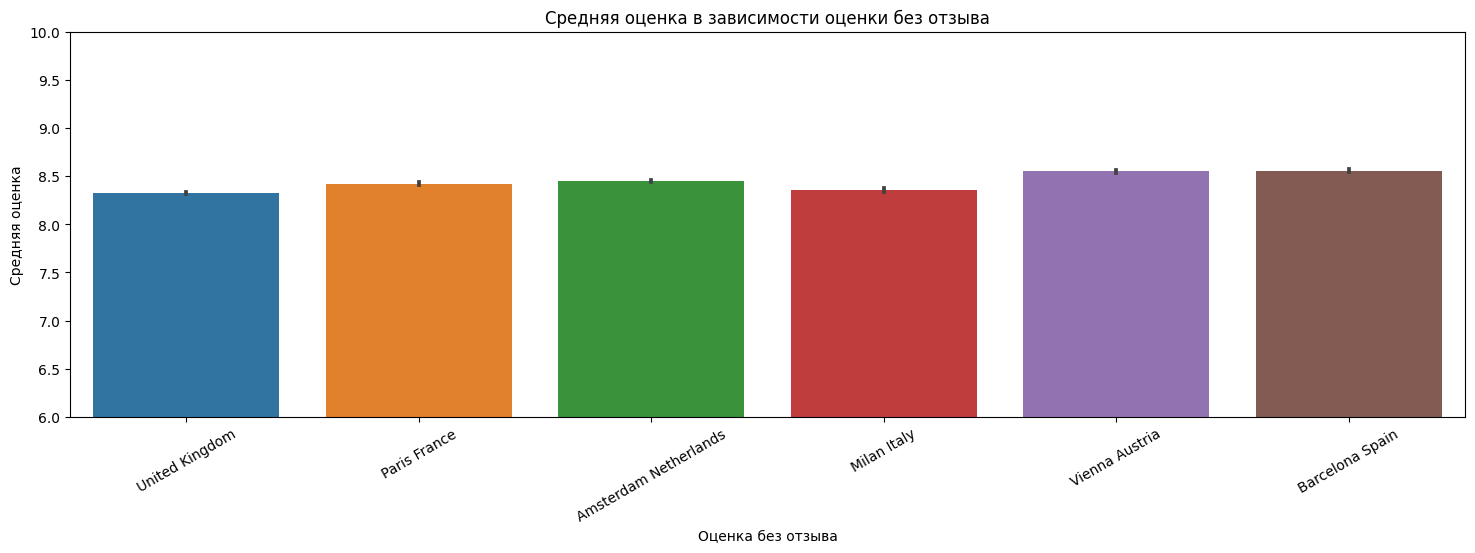

In [51]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='country',y='reviewer_score'
            )
axes.set(xlabel='Оценка без отзыва', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости оценки без отзыва')
axes.set_ylim(6, 10)

### 3.2.2. признак 'tags'



#### Один из самых удобных признаков 

##### В этом признаке храниться такая информация как вид поездки, отправка отзыва через устройство, статус гостя, количество прожитых ночей в гостинице, далее количество и вид комнат в номере

 

In [52]:
# очистим строку oт лишних символов
def tagsclean(tags):
    tags = tags.replace('[', '')
    tags = tags.replace(']', '')
    tags = tags.replace("'", '')
    
    return tags.split(',')
    
data['tags_clean'] = data['tags'].apply(tagsclean)

In [53]:
# import ast
dict_tags = {}

for list_tag in data['tags']:
    list_tags = ast.literal_eval(list_tag)
    
    if type(list_tags) is list:
       for tag in list_tags:
           if tag.strip() in dict_tags:
              dict_tags[tag.strip()] += 1
           else:
              dict_tags[tag.strip()] = 1
sorted_tuple = sorted(dict_tags.items(), key=lambda x: x[1],reverse=True)
dict_tags_sort =  dict(sorted_tuple)



#### 3.2.2.1. признак 'trip'

#### Начнем с самого часто встречающегося - вида поездки.

In [54]:
# Выделим тип поездки из поля тэгов 

def trip(tags):
    
    for curr_tag in tags:
        
        if 'trip' in curr_tag.strip():
            return curr_tag.strip()
        
    return 'Not a trip'

data['trip'] = data['tags_clean'].apply(trip)

(6.0, 10.0)

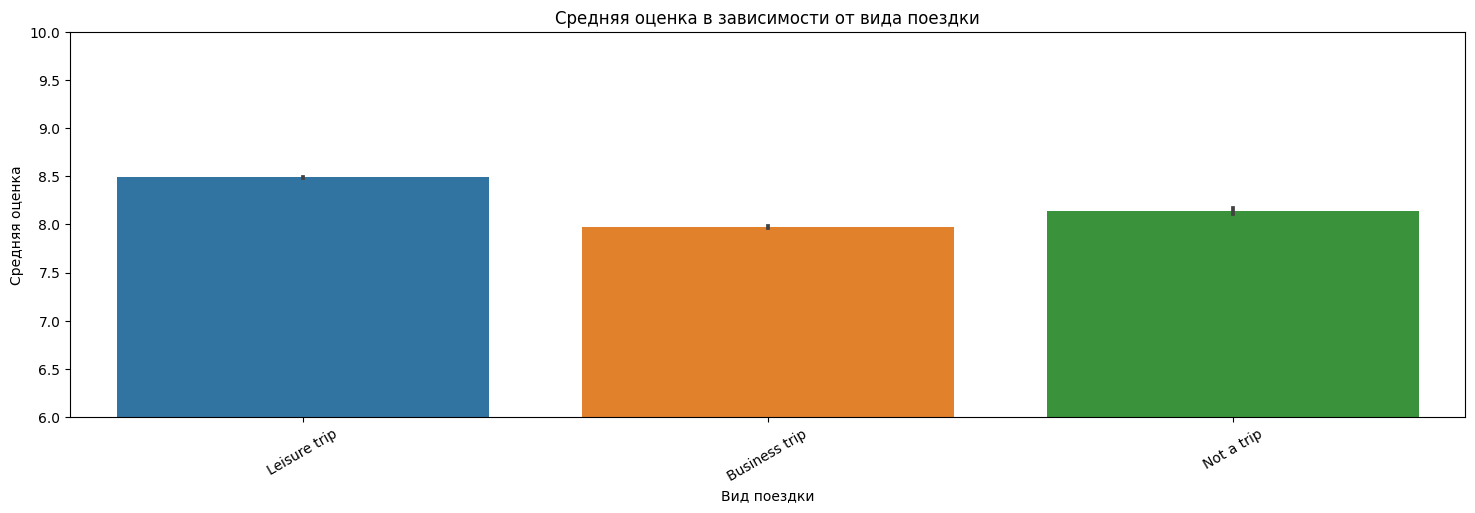

In [55]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='trip',y='reviewer_score'
            )
axes.set(xlabel='Вид поездки', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от вида поездки')
axes.set_ylim(6, 10)

#### 3.2.2.2. признак 'mobile'

#### Создаем признак по способу отправки отзыва, через мобильное или не мобильное устройство 

In [56]:
def mobile(tags):
    
    for curr_tag in tags:
        if 'mobile' in curr_tag:
            return 1
    return 0
data['mobile'] = data['tags_clean'].apply(mobile)


(6.0, 10.0)

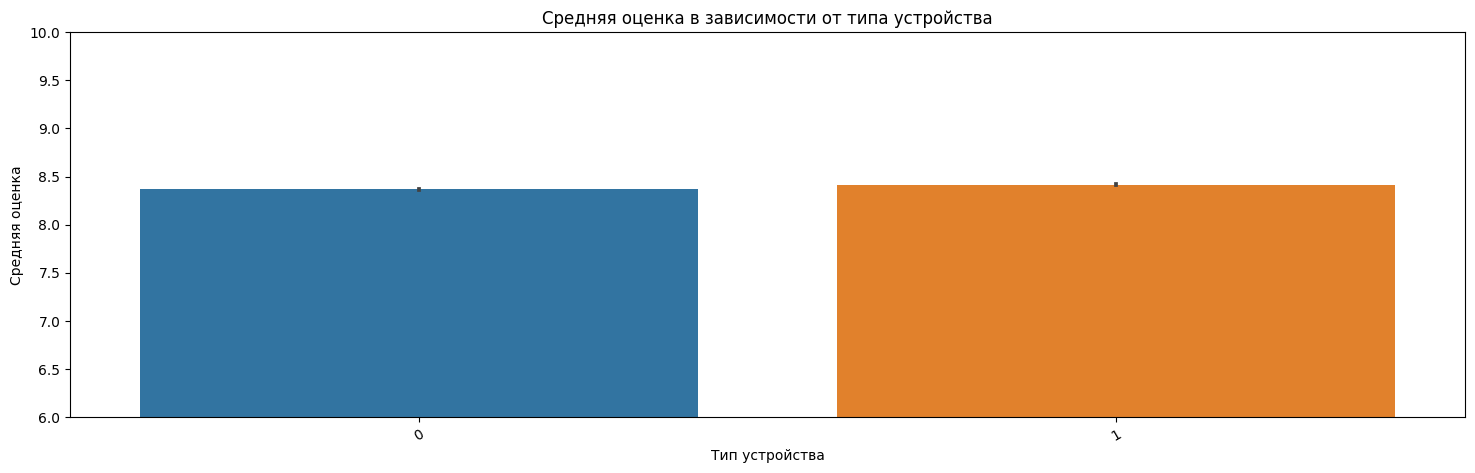

In [57]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='mobile',y='reviewer_score'
            )
axes.set(xlabel='Тип устройства', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от типа устройства')
axes.set_ylim(6, 10)

#### 3.2.2.3. признак 'guest_stat'

#### Создаем признак который условно называем статусом гостя 

In [58]:
def guest_status(tags):
    status = ['Couple', 'Solo traveler', 'Group', 'Family with young children',
              'Family with older children', 'Travelers with friends', 'With a pet']
    
    for curr_stat in status:
        if curr_stat in tags:
            return curr_stat
        
    return None

data['guest_stat'] = data['tags'].apply(guest_status)

(6.0, 10.0)

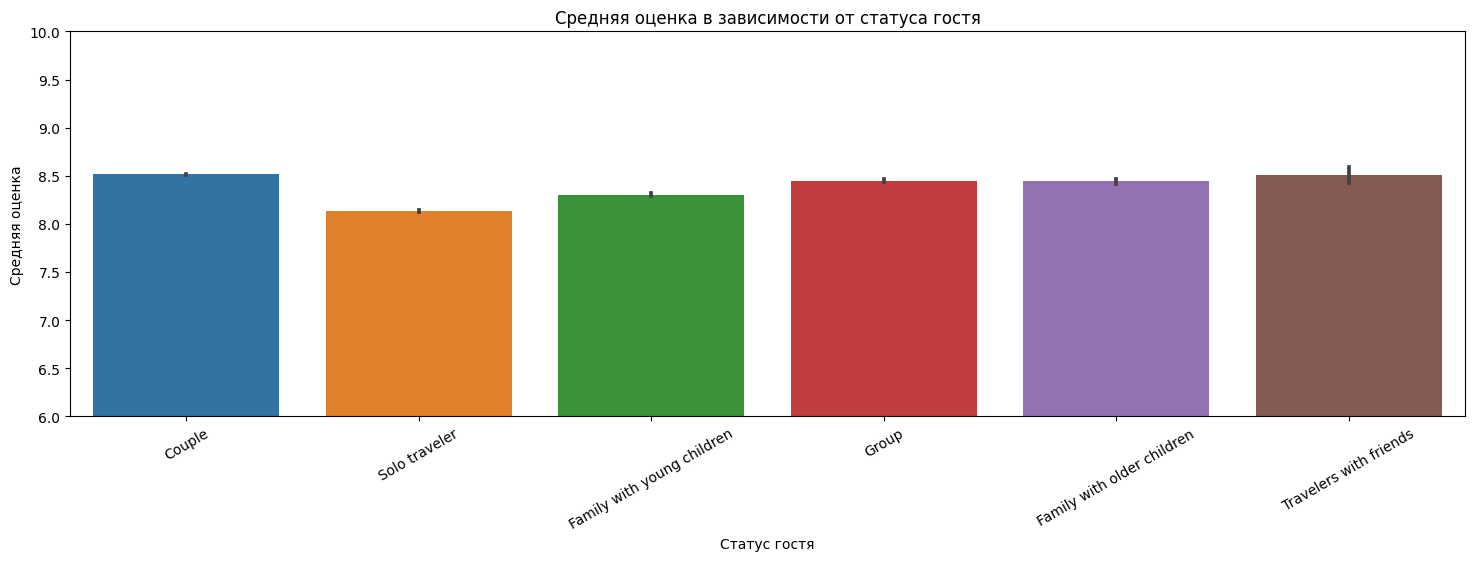

In [59]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='guest_stat',y='reviewer_score'
            )
axes.set(xlabel='Статус гостя', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от статуса гостя')
axes.set_ylim(6, 10)

#### 3.2.2.4. признак 'night_quantity'

#### Создаем признак количество ночей проживания 

In [60]:
# import re

def extract_night_quantity(tag):
    # Используем регулярное выражение для поиска числа в строке
    match = re.search(r'\b\d+\b', tag)
    if match:
        return match.group()  # Возвращаем найденное число
    else:
        return '0'  # Если число не найдено, возвращаем 0

def night_quant(tags):
    for tag in tags:
        if 'Stayed' in tag:
            return extract_night_quantity(tag)
    return '0'

data['night_quantity'] = data['tags_clean'].apply(night_quant)


(4.0, 10.0)

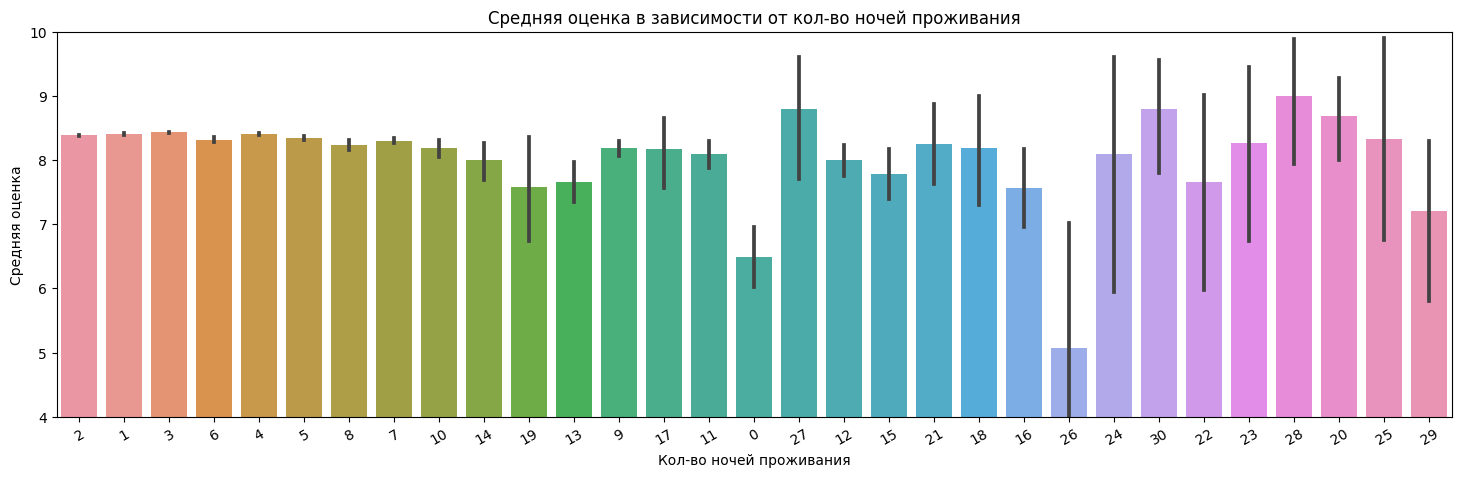

In [61]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='night_quantity',y='reviewer_score'
            )
axes.set(xlabel='Кол-во ночей проживания', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-во ночей проживания')
axes.set_ylim(4, 10)

#### 3.2.2.5. признак 'rooms'

#### Создаем признак характеристика комнаты 

In [62]:
def room_def(tags):
    
    for room in tags:
        if 'Room' in room:
            return room
        if 'Suite' in room:
            return room
    return 'Unknown'

data['rooms'] = data['tags_clean'].apply(room_def)

(6.0, 10.0)

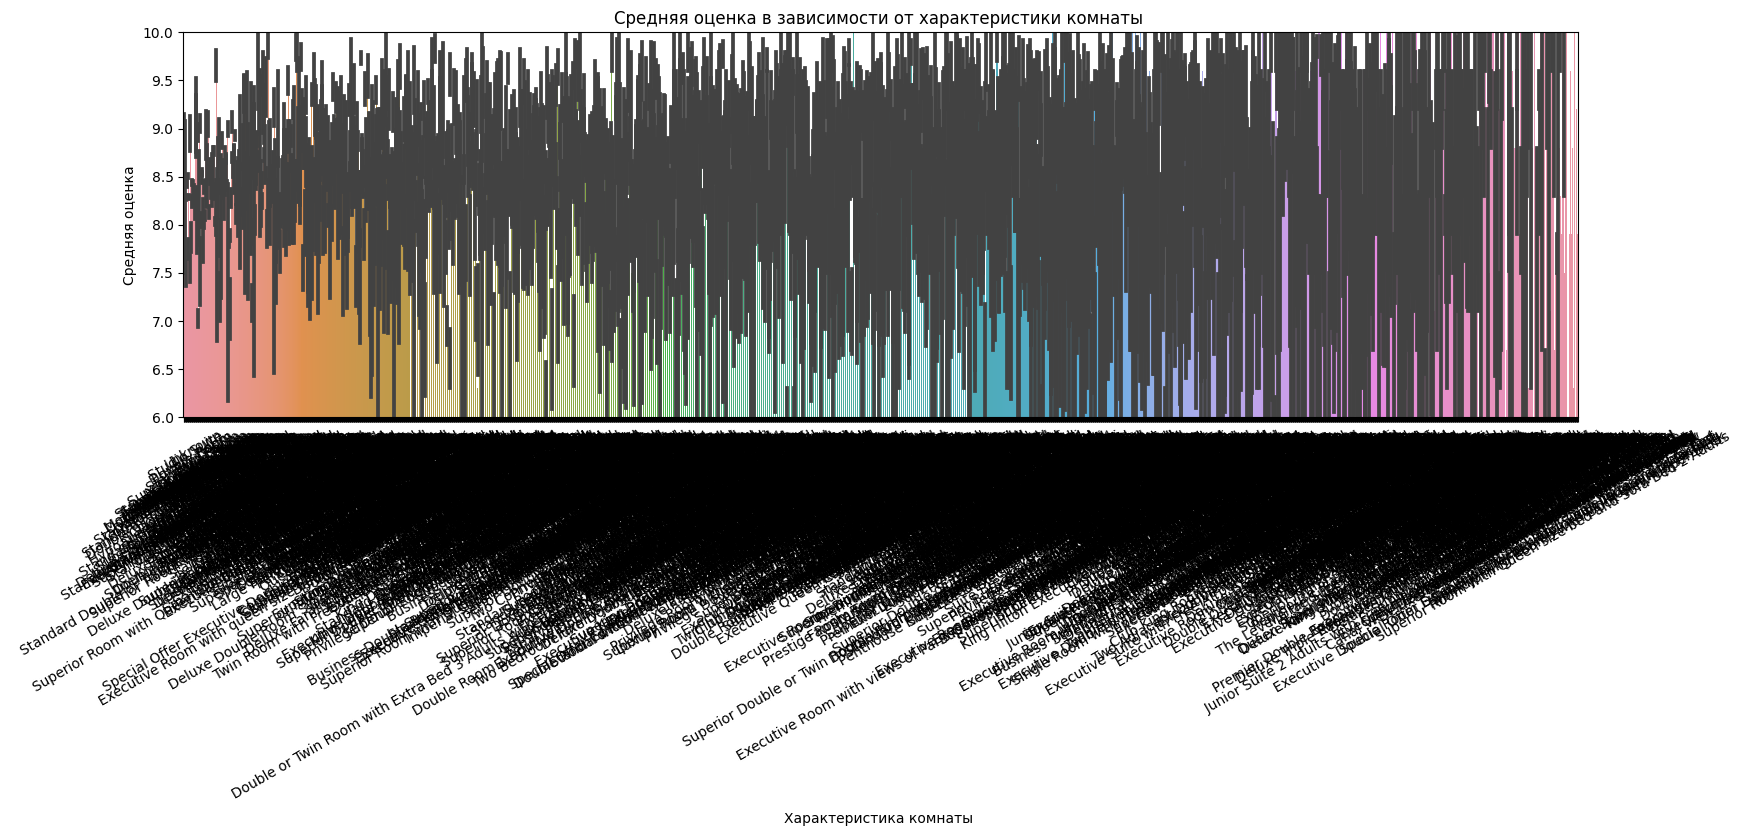

In [63]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='rooms',y='reviewer_score'
            )
axes.set(xlabel='Характеристика комнаты ', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от характеристики комнаты ')
axes.set_ylim(6, 10)

In [64]:
# # Строю график, для визуализации информации 
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
# histplot = sns.histplot(data=data, x='rooms', ax=axes[0]);
# histplot.set_title('Количество комнат в гостинице Distribution');
# boxplot = sns.boxplot(data=data, x='rooms', ax=axes[1]);
# boxplot.set_title('Количество комнат в гостинице Boxplot');



### 3.2.3. Разбор признака 'review_date'

#### Перевожу существующий признак времени во все возможные форматы дат для определения зависимости 

In [65]:
# Преобразуем столбец review_date в datetime и создадаю признаки день, месяц, год, и день недели. 
data['review_date']=pd.to_datetime(data['review_date'])
data['day'] = data['review_date'].dt.day
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year
data['dayofweek'] = data['review_date'].dt.dayofweek

#### 3.2.3.1. признак 'day'

(6.0, 10.0)

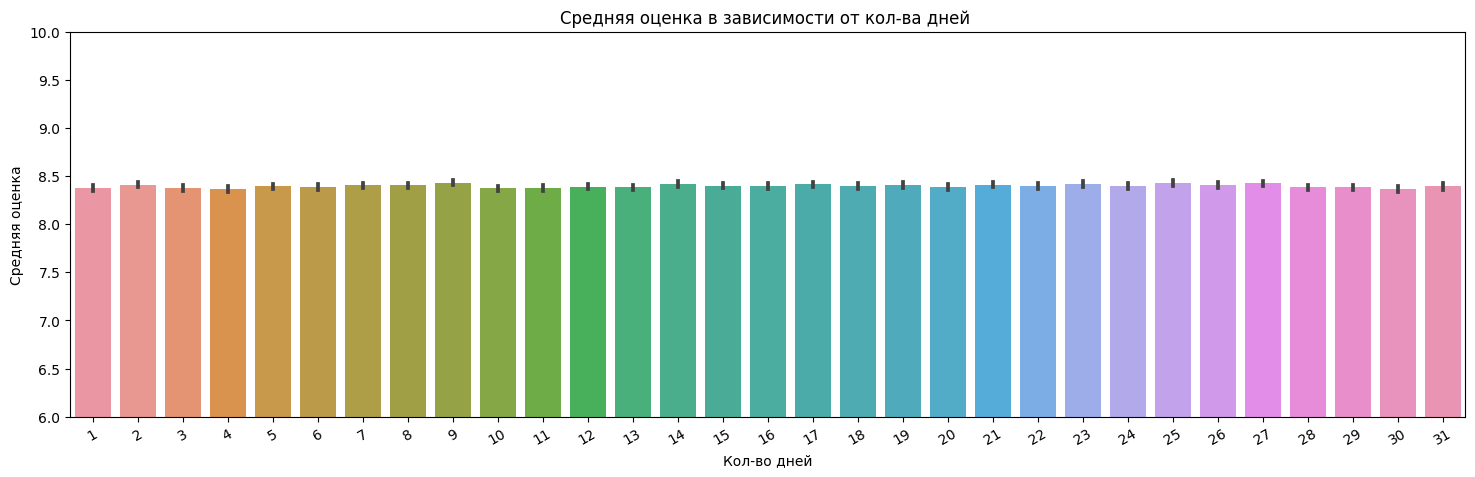

In [66]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='day',y='reviewer_score'
            )
axes.set(xlabel='Кол-во дней', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва дней ')
axes.set_ylim(6, 10)

#### 3.2.3.2. признак 'month'

(6.0, 10.0)

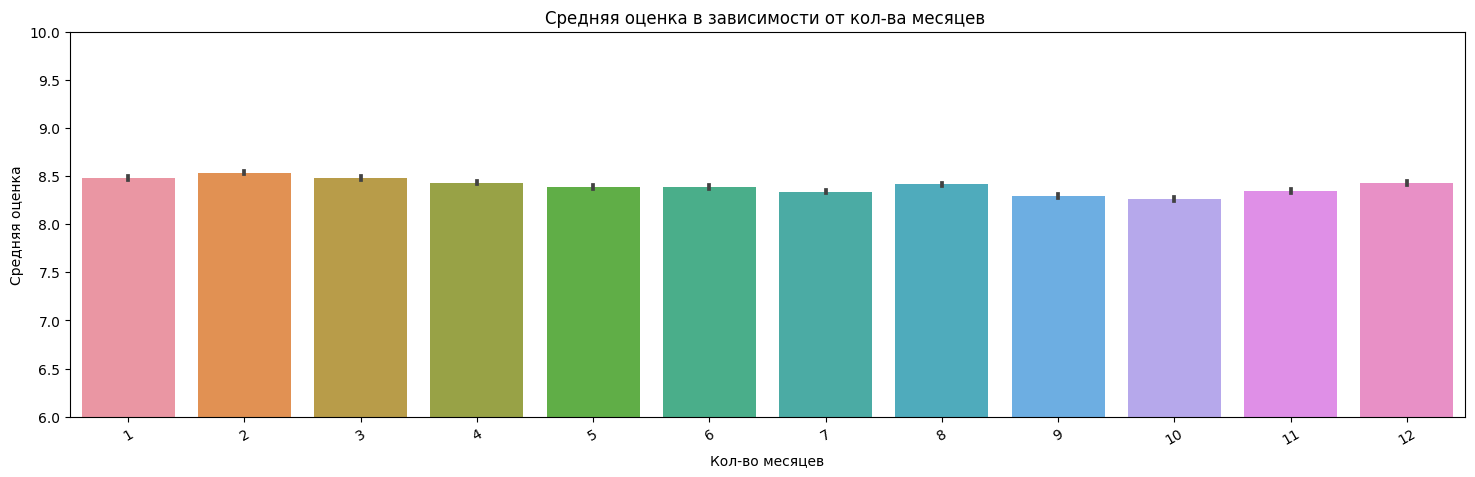

In [67]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='month',y='reviewer_score'
            )
axes.set(xlabel='Кол-во месяцев', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва месяцев ')
axes.set_ylim(6, 10)

#### 3.2.3.3. признак 'year'

(6.0, 10.0)

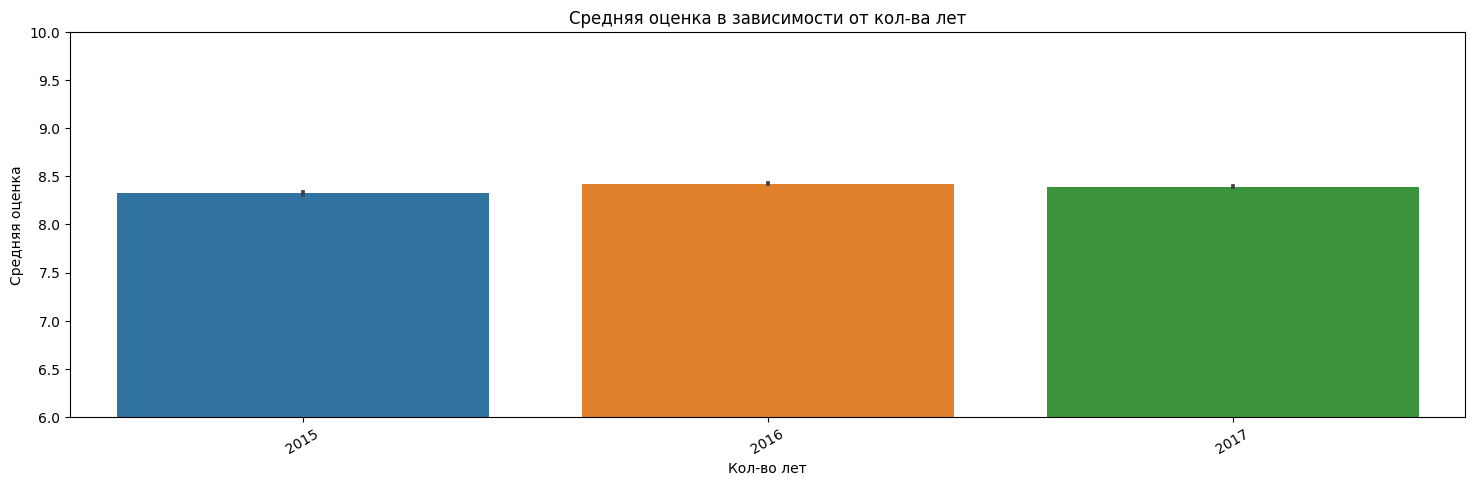

In [68]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='year',y='reviewer_score'
            )
axes.set(xlabel='Кол-во лет', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва лет')
axes.set_ylim(6, 10)

#### 3.2.3.4. признак 'dayofweek'

(6.0, 10.0)

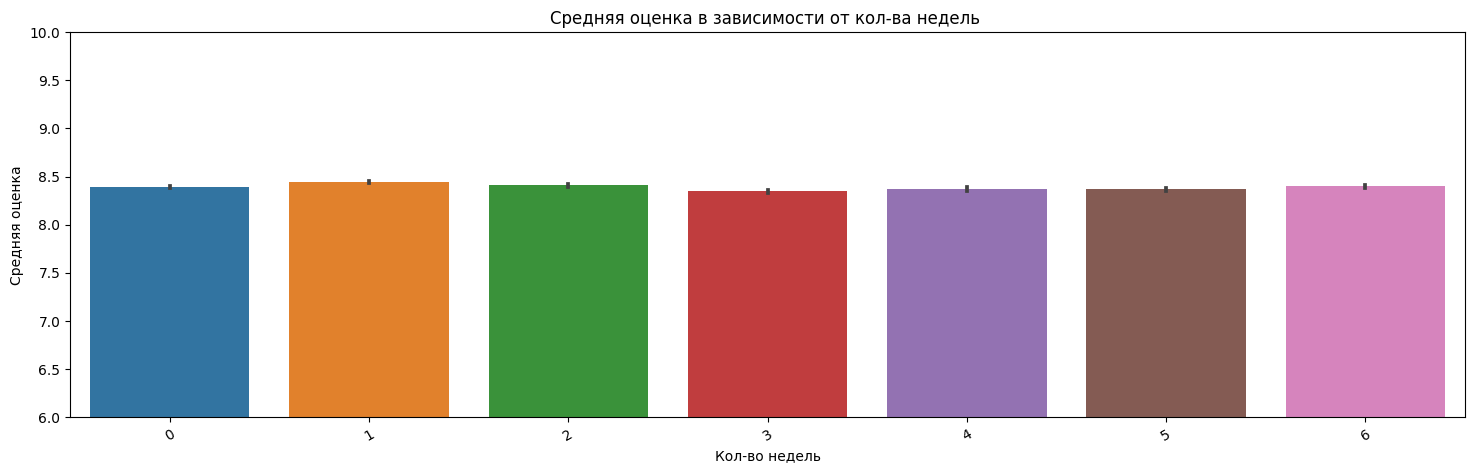

In [69]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='dayofweek',y='reviewer_score'
            )
axes.set(xlabel='Кол-во недель', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва недель ')
axes.set_ylim(6, 10)

### 3.2.4. Разбор признака 'review_date'

#### Пробую создать новые признаки методом пересчета символов и количеством слов. Для анализу беру признаки типа 'object'

In [70]:
# import nltk
# from nltk.tokenize import word_tokenize

# Инициализация NLTK
nltk.download('punkt')

# Функция для подсчета количества слов в отзыве
def count_words(text):
    tokens = word_tokenize(text.lower())  # Токенизация и приведение к нижнему регистру
    return len(tokens)


data['word_count_negative'] = data['negative_review'].apply(count_words)
data['word_count_positive'] = data['positive_review'].apply(count_words)
data['word_count_hotel_name'] = data['hotel_name'].apply(count_words)
data['word_count_hotel_address'] = data['hotel_address'].apply(count_words)
data['word_count_rooms'] = data['rooms'].apply(count_words)
# Функция для подсчета количества символов в отзыве
def count_characters(text):
    return len(text)


data['char_count_negative'] = data['negative_review'].apply(count_characters)
data['char_count_positive'] = data['positive_review'].apply(count_characters)
data['char_count_hotel_name'] = data['hotel_name'].apply(count_characters)
data['char_count_hotel_address'] = data['hotel_address'].apply(count_characters)
data['char_count_rooms'] = data['rooms'].apply(count_characters)





[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


#Надо переменовать все графики ниже 

#### 3.2.4.1. Признак 'word_count_negative'



(6.0, 10.0)

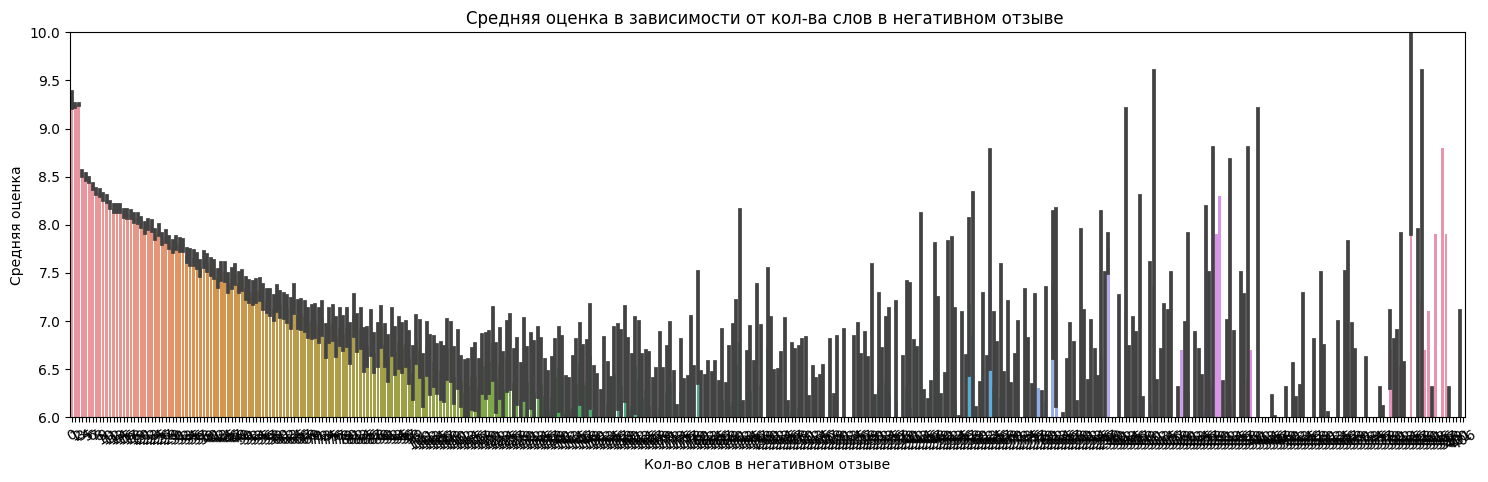

In [71]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='word_count_negative',y='reviewer_score'
            )
axes.set(xlabel='Кол-во слов в негативном отзыве', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва слов в негативном отзыве ')
axes.set_ylim(6, 10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


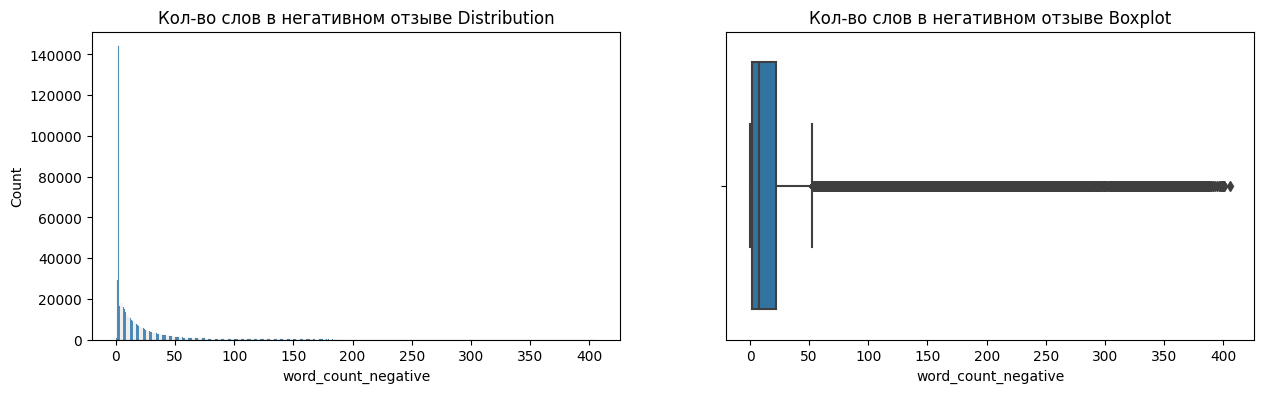

In [72]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='word_count_negative', ax=axes[0]);
histplot.set_title('Кол-во слов в негативном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='word_count_negative', ax=axes[1]);
boxplot.set_title('Кол-во слов в негативном отзыве Boxplot');

In [73]:
data['standardized_word_count_negative'] = scaler.fit_transform(data[['word_count_negative']])



#### 3.2.4.2. Признак 'word_count_positive'



(6.0, 10.0)

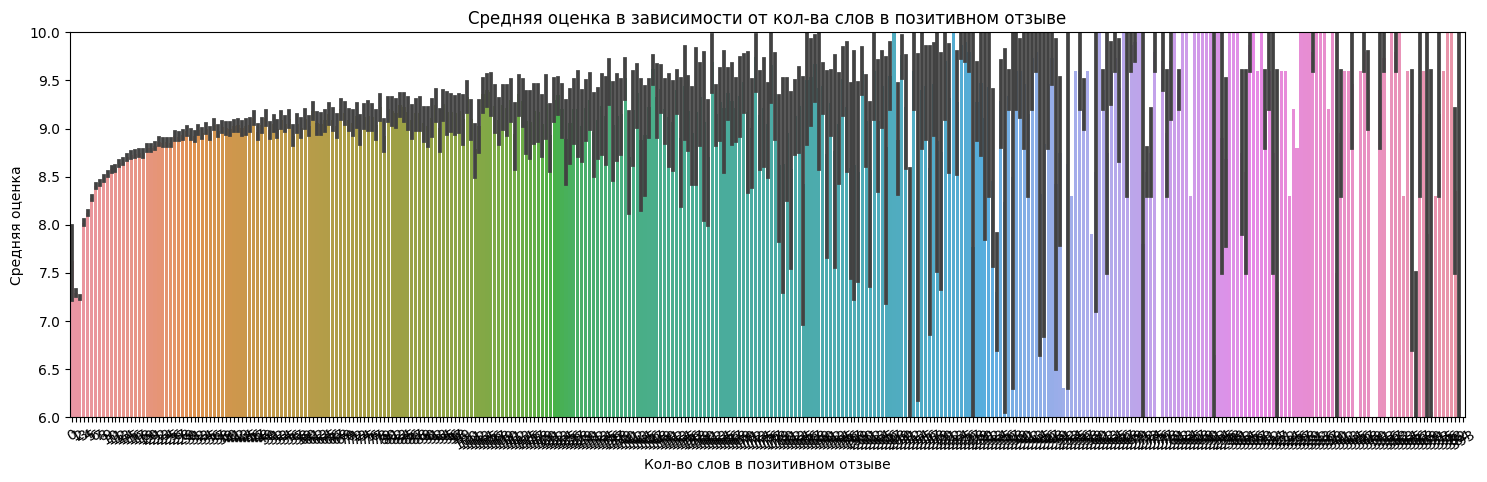

In [74]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='word_count_positive',y='reviewer_score'
            )
axes.set(xlabel='Кол-во слов в позитивном отзыве', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва слов в позитивном отзыве')
axes.set_ylim(6, 10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


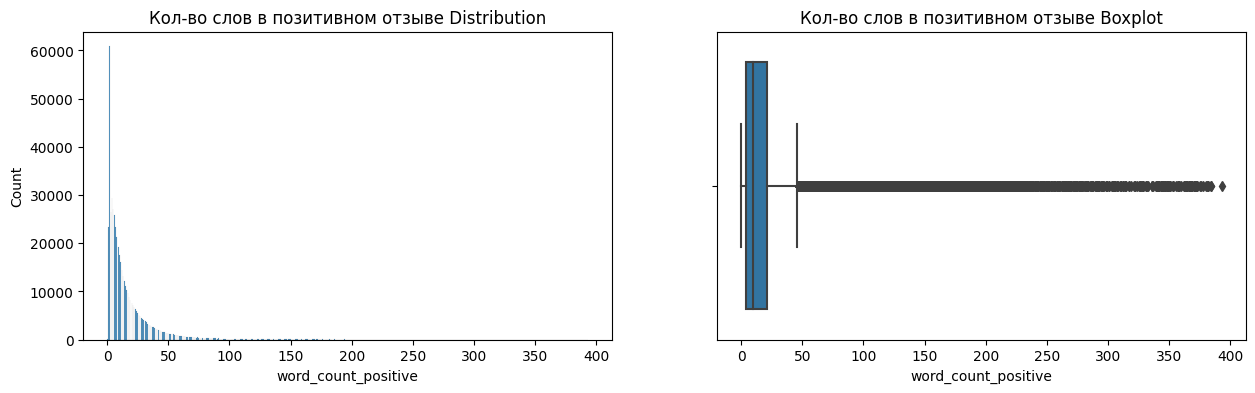

In [75]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='word_count_positive', ax=axes[0]);
histplot.set_title('Кол-во слов в позитивном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='word_count_positive', ax=axes[1]);
boxplot.set_title('Кол-во слов в позитивном отзыве Boxplot');

In [76]:
data['standardized_word_count_positive'] = scaler.fit_transform(data[['word_count_positive']])



#### 3.2.4.3. Признак 'word_count_hotel_name'



(6.0, 10.0)

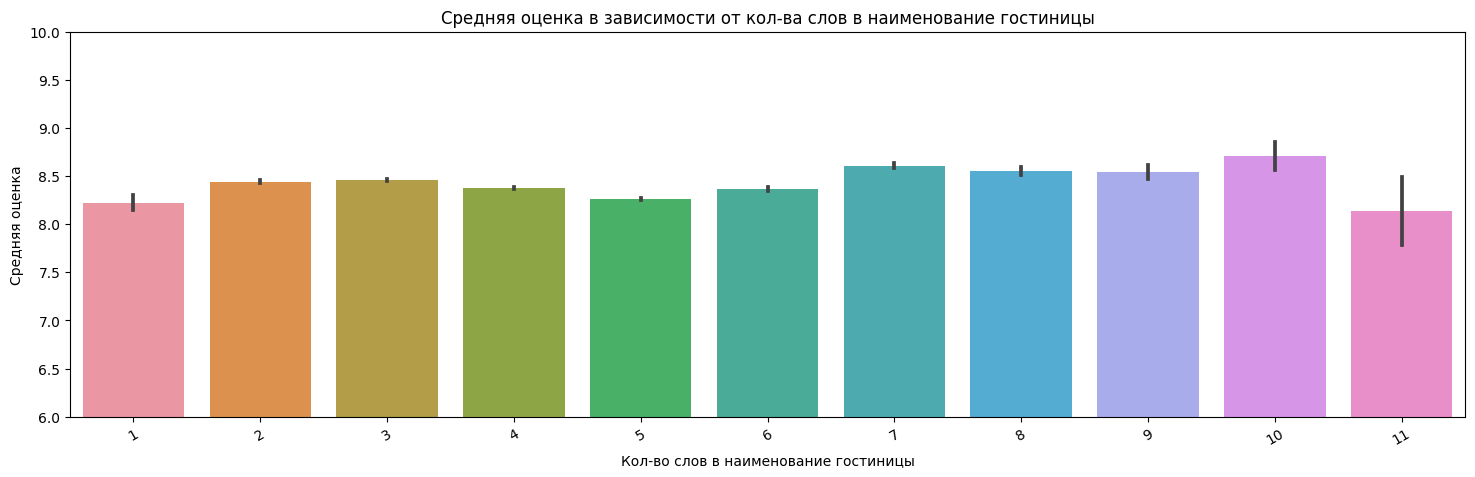

In [77]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='word_count_hotel_name',y='reviewer_score'
            )
axes.set(xlabel='Кол-во слов в наименование гостиницы', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва слов в наименование гостиницы')
axes.set_ylim(6, 10)

#### 3.2.4.4. Признак 'word_count_hotel_address'



(6.0, 10.0)

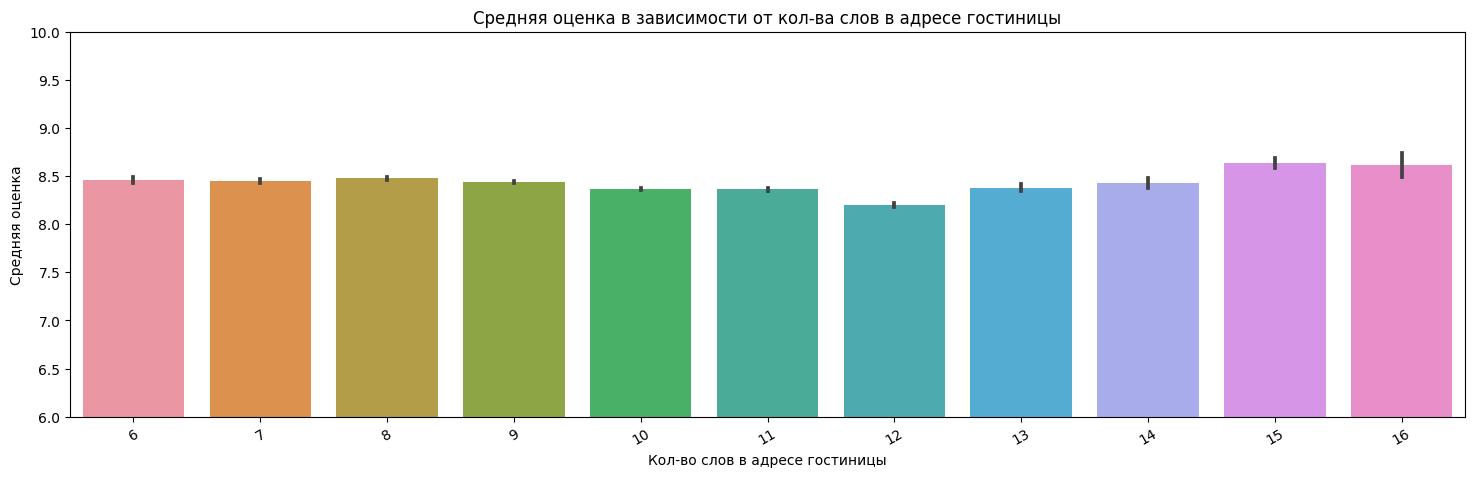

In [78]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='word_count_hotel_address',y='reviewer_score'
            )
axes.set(xlabel='Кол-во слов в адресе гостиницы', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва слов в адресе гостиницы')
axes.set_ylim(6, 10)

#### 3.2.4.5. Признак 'word_count_rooms'



(6.0, 10.0)

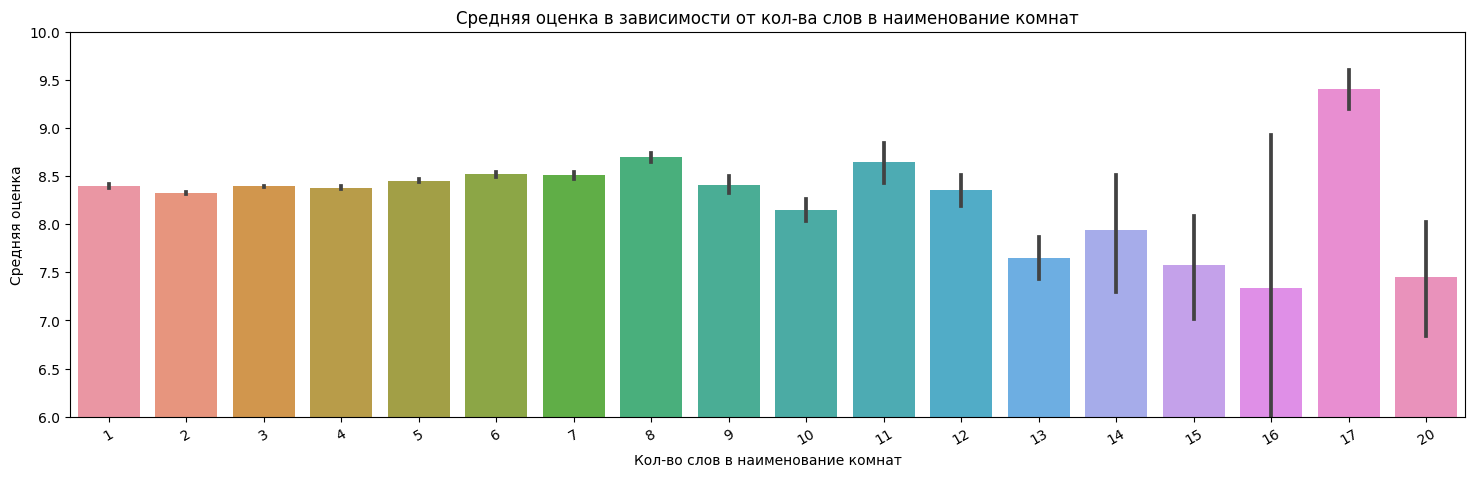

In [79]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='word_count_rooms',y='reviewer_score'
            )
axes.set(xlabel='Кол-во слов в наименование комнат', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва слов в наименование комнат')
axes.set_ylim(6, 10)

#### 3.2.4.6. Признак 'char_count_negative'



(6.0, 10.0)

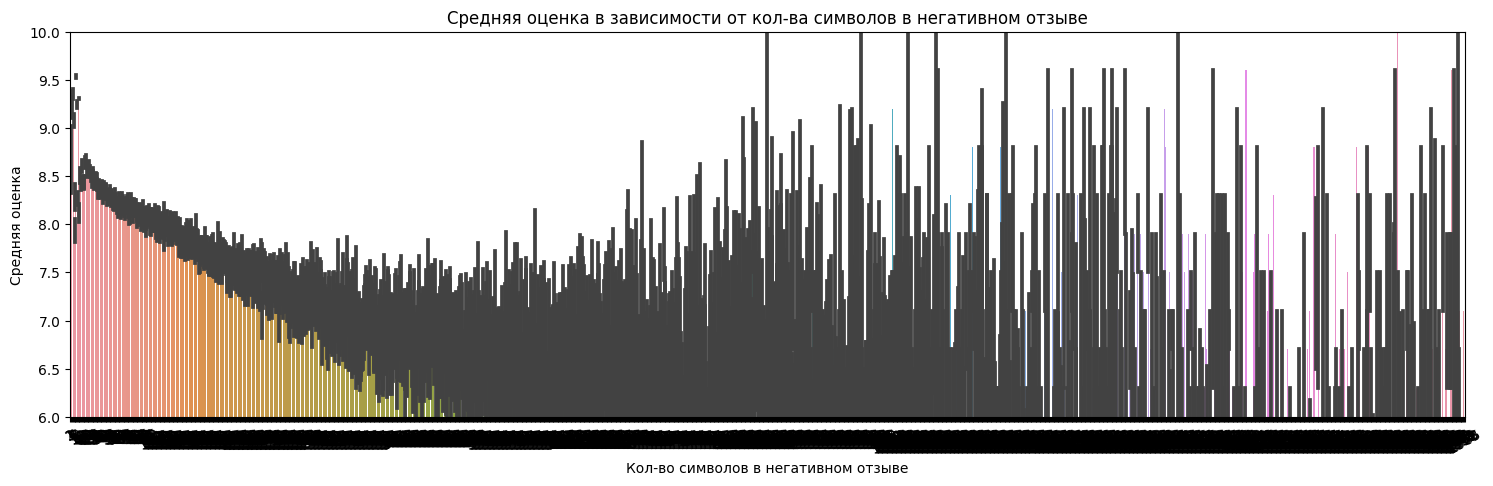

In [80]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='char_count_negative',y='reviewer_score'
            )
axes.set(xlabel='Кол-во символов в негативном отзыве', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва символов в негативном отзыве')
axes.set_ylim(6, 10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


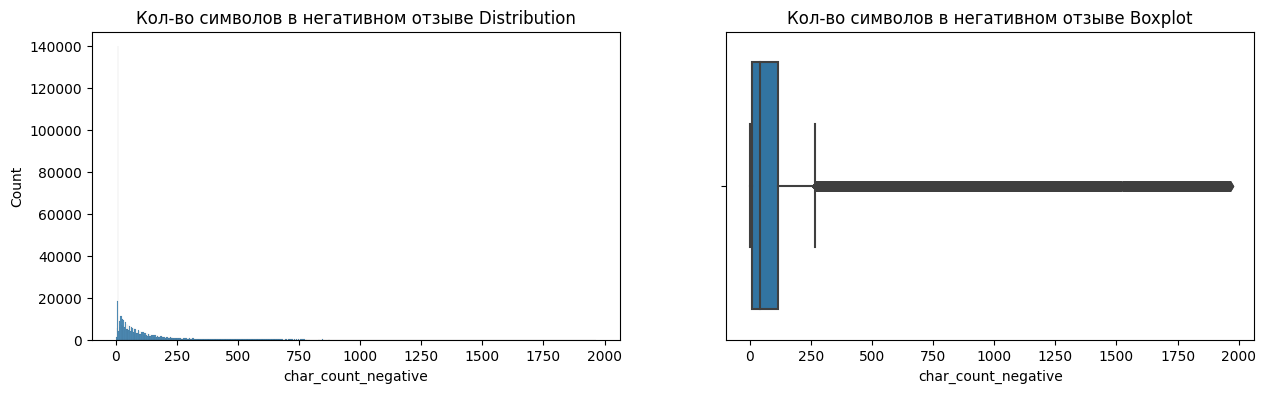

In [81]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='char_count_negative', ax=axes[0]);
histplot.set_title('Кол-во символов в негативном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='char_count_negative', ax=axes[1]);
boxplot.set_title('Кол-во символов в негативном отзыве Boxplot');

In [82]:
data['standardized_char_count_negative'] = scaler.fit_transform(data[['char_count_negative']])



#### 3.2.4.7. Признак 'char_count_positive'



(6.0, 10.0)

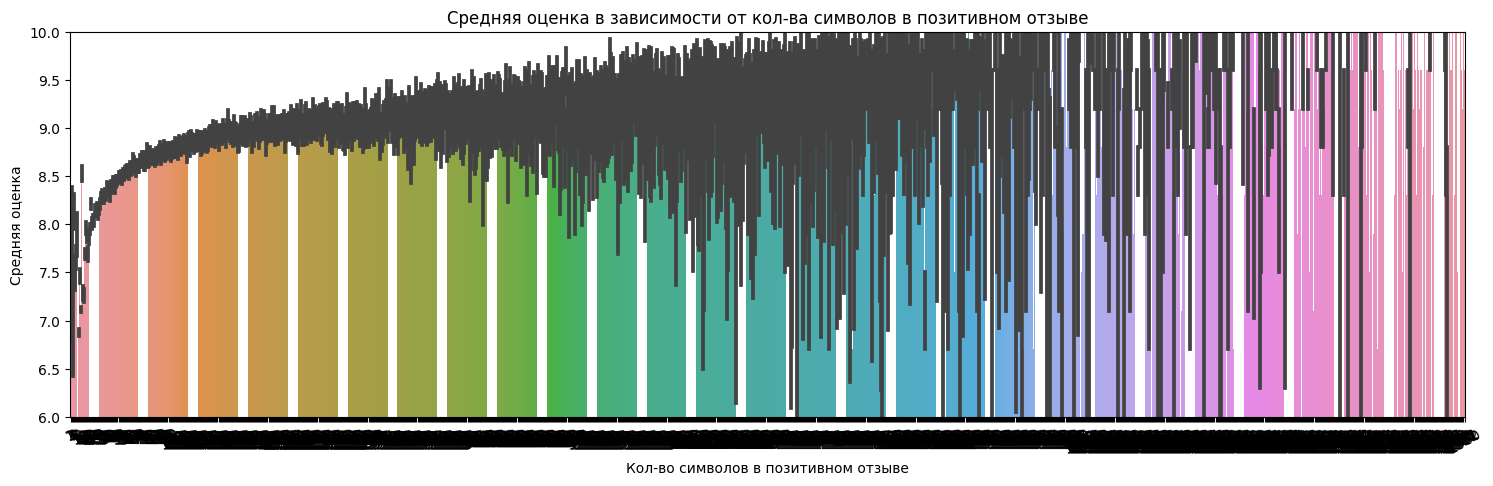

In [83]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='char_count_positive',y='reviewer_score'
            )
axes.set(xlabel='Кол-во символов в позитивном отзыве', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва символов в позитивном отзыве')
axes.set_ylim(6, 10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


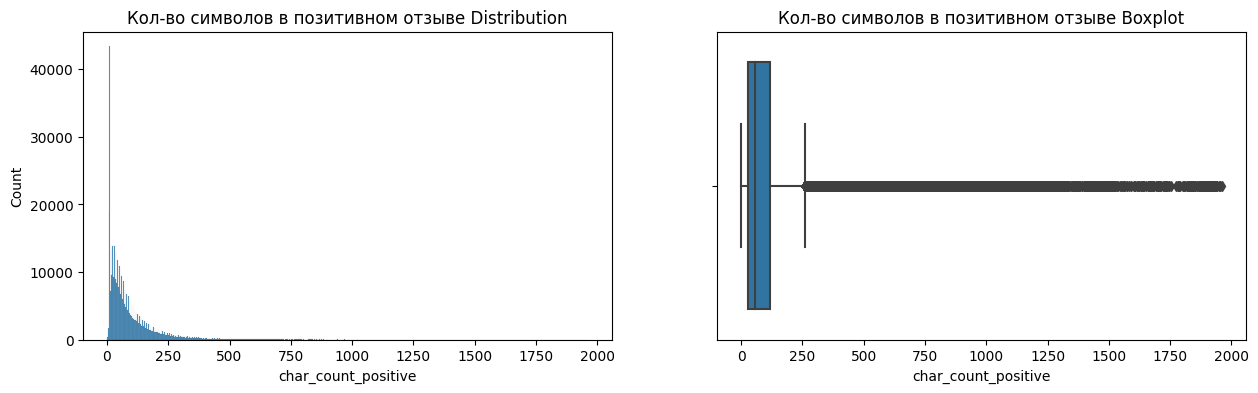

In [84]:
# Строю график, для визуализации информации 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='char_count_positive', ax=axes[0]);
histplot.set_title('Кол-во символов в позитивном отзыве Distribution');
boxplot = sns.boxplot(data=data, x='char_count_positive', ax=axes[1]);
boxplot.set_title('Кол-во символов в позитивном отзыве Boxplot');

In [85]:
data['standardized_char_count_positive'] = scaler.fit_transform(data[['char_count_positive']])

#### 3.2.4.8. Признак 'char_count_hotel_name'



(6.0, 10.0)

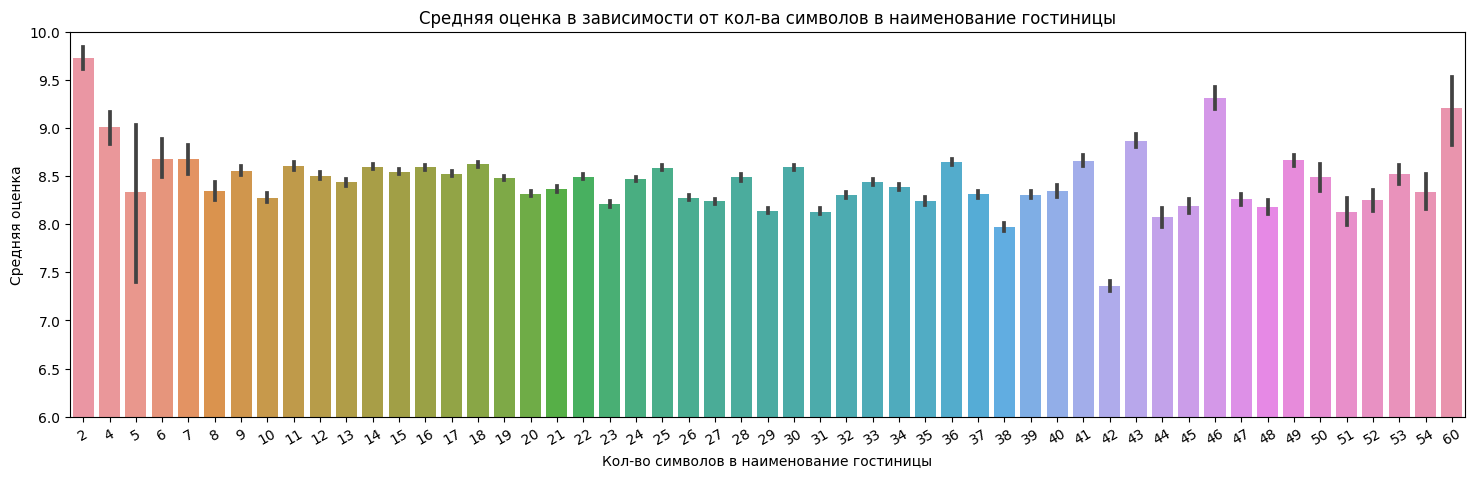

In [86]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='char_count_hotel_name',y='reviewer_score'
            )
axes.set(xlabel='Кол-во символов в наименование гостиницы', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва символов в наименование гостиницы')
axes.set_ylim(6, 10)


#### 3.2.4.9. Признак 'char_count_hotel_address'



(6.0, 10.0)

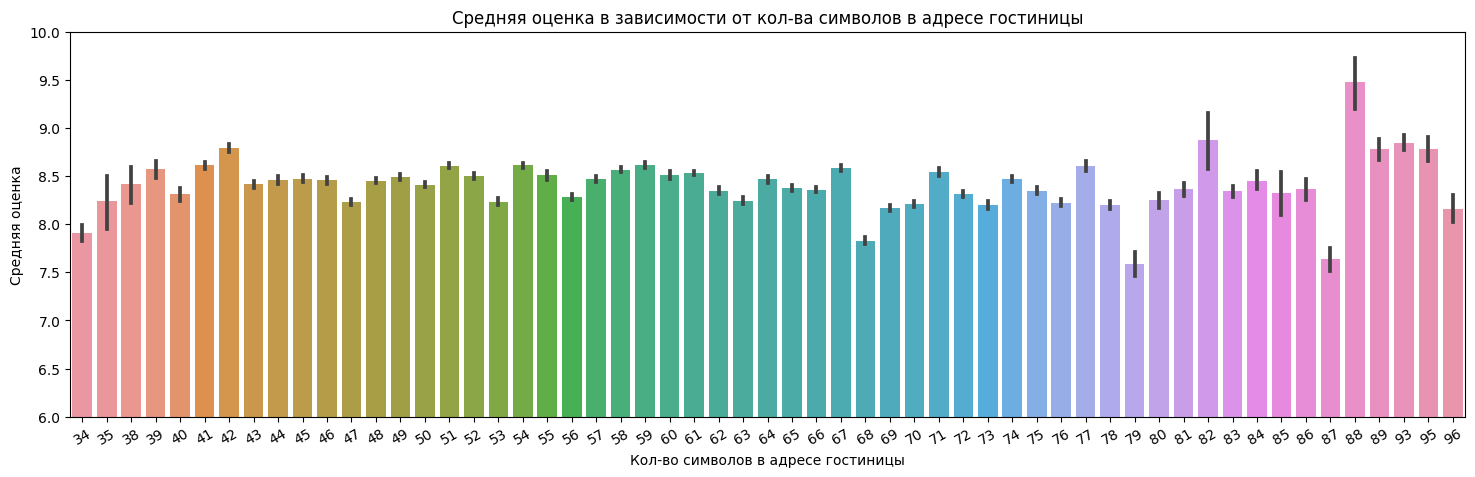

In [87]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='char_count_hotel_address',y='reviewer_score'
            )
axes.set(xlabel='Кол-во символов в адресе гостиницы', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва символов в адресе гостиницы')
axes.set_ylim(6, 10)


#### 3.2.4.10. Признак 'char_count_rooms'



(6.0, 10.0)

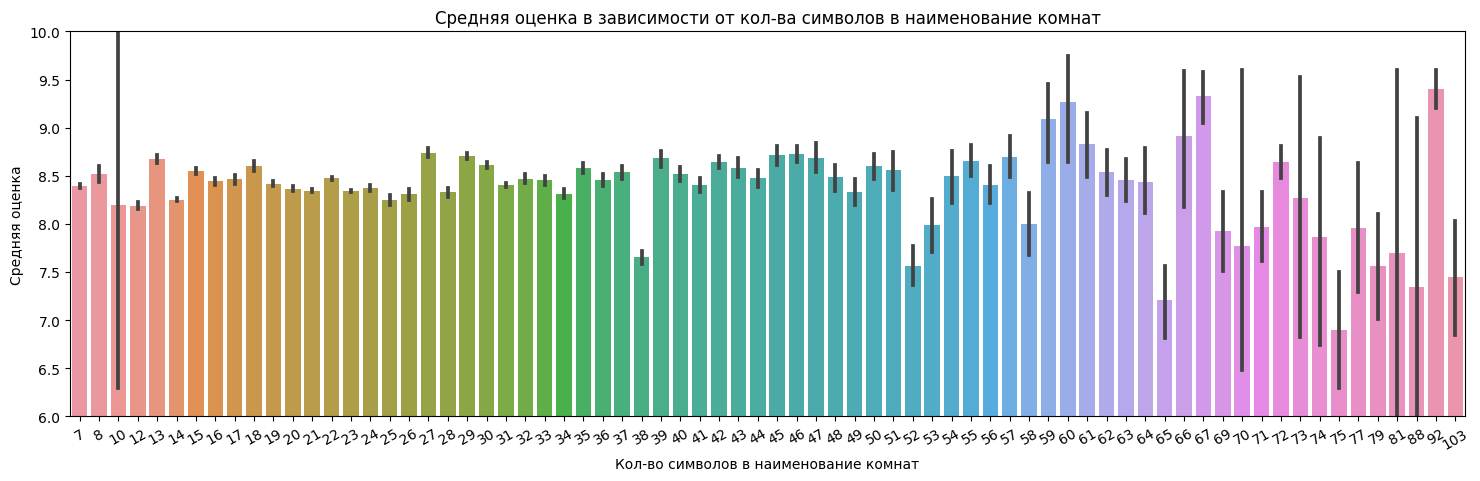

In [88]:
fig, axes = plt.subplots(1, figsize=(18, 5))
plt.subplots_adjust(wspace=0.6)
sns.barplot(data[data['sample']==1],x='char_count_rooms',y='reviewer_score'
            )
axes.set(xlabel='Кол-во символов в наименование комнат', ylabel='Средняя оценка')
axes.xaxis.set_tick_params(rotation = 30)
axes.set_title('Средняя оценка в зависимости от кол-ва символов в наименование комнат')
axes.set_ylim(6, 10)


Удаляю признаки, которые не несут полезной информации и которые были уже обработаны

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 53 columns):
 #   Column                                                   Non-Null Count   Dtype         
---  ------                                                   --------------   -----         
 0   hotel_address                                            515738 non-null  object        
 1   additional_number_of_scoring                             515738 non-null  int64         
 2   review_date                                              515738 non-null  datetime64[ns]
 3   average_score                                            515738 non-null  float64       
 4   hotel_name                                               515738 non-null  object        
 5   reviewer_nationality                                     515738 non-null  object        
 6   negative_review                                          515738 non-null  object        
 7   review_total_negative_word_counts     

### 4. Признак 'review_total_negative_word_counts'           

In [90]:
data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,word_count_rooms,char_count_negative,char_count_positive,char_count_hotel_name,char_count_hotel_address,char_count_rooms,standardized_word_count_negative,standardized_word_count_positive,standardized_char_count_negative,standardized_char_count_positive
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,2,262,337,14,34,14,1.106404,2.027897,1.129265,2.099969
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,2,44,11,17,53,14,-0.304645,-0.673984,-0.334332,-0.724492
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,2,9,27,42,43,12,-0.579972,-0.580816,-0.569313,-0.585868
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,3,11,155,24,60,26,-0.545556,0.444036,-0.555886,0.523122
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,5,11,32,14,66,30,-0.545556,-0.534232,-0.555886,-0.542548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,2017-04-19,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,5,11,35,15,74,27,-0.545556,-0.394479,-0.555886,-0.516556
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2017-02-13,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,3,11,436,29,61,23,-0.545556,3.472006,-0.555886,2.957703
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2016-02-07,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,2,52,47,23,56,14,-0.270229,-0.394479,-0.280622,-0.412588
515736,31 Great Cumberland Place Westminster Borough ...,365,2017-05-21,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,3,11,28,22,75,21,-0.545556,-0.534232,-0.555886,-0.577204


In [91]:
# Удаляю
data = data.drop(['tags', 'tags_clean', 'review_date'], axis = 1)

## 3. РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ

Есть два существестнных признаков, а именно: 
* 'sample' == 1 - пометка на встроенном df_train;
* 'reviewer_score' - оценка, которую рецензент поставил отелю на основе своего опыта. 

Зная главные признаки, начинаю строить гистрограммы и выявлять зависимость, если зависимости нет, то убираю эти признаки 

### 1. Признак 'additional_number_of_scoring'


In [92]:
def extract_day(value):
    # Разделение строки по пробелу и извлечение первого элемента, который должен быть числом
    return int(value.split()[0])

# Применение функции к столбцу 'days_since_review' и создание нового столбца 'day_sin_rev_mean'
data['day_sin_rev_mean'] = data['days_since_review'].apply(extract_day)


In [93]:
#  Удаляю
data = data.drop('days_since_review', axis = 1)

In [94]:
# Определение функции get_average_score_mean
def get_average_score_mean(value):
    value = value.strip().lower()
    
    if value not in get_average_score_mean.unique_values:
        get_average_score_mean.unique_values[value] = len(get_average_score_mean.unique_values) + 1
    
    return get_average_score_mean.unique_values[value]

# Инициализация словаря для хранения уникальных значений
get_average_score_mean.unique_values = {}

# Применение функции к столбцу 'rooms' и сохранение результата в новом столбце 'rooms'
data['rooms'] = data['rooms'].apply(get_average_score_mean)

In [95]:
data['standardized_rooms'] = scaler.fit_transform(data[['rooms']])

In [96]:
data['night_quantity']=data['night_quantity'].astype('int32')

## Кодирование признаков 

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 51 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   hotel_address                                            515738 non-null  object 
 1   additional_number_of_scoring                             515738 non-null  int64  
 2   average_score                                            515738 non-null  float64
 3   hotel_name                                               515738 non-null  object 
 4   reviewer_nationality                                     515738 non-null  object 
 5   negative_review                                          515738 non-null  object 
 6   review_total_negative_word_counts                        515738 non-null  int64  
 7   total_number_of_reviews                                  515738 non-null  int64  
 8   positive_revie

In [98]:
# import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

In [99]:
encoder = ce.OneHotEncoder(cols=['trip'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['trip'])
data = pd.concat([data, type_bin], axis=1)

In [100]:
encoder = ce.OneHotEncoder(cols=['guest_stat'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['guest_stat'])
data = pd.concat([data, type_bin], axis=1)

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 66 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   hotel_address                                            515738 non-null  object 
 1   additional_number_of_scoring                             515738 non-null  int64  
 2   average_score                                            515738 non-null  float64
 3   hotel_name                                               515738 non-null  object 
 4   reviewer_nationality                                     515738 non-null  object 
 5   negative_review                                          515738 non-null  object 
 6   review_total_negative_word_counts                        515738 non-null  int64  
 7   total_number_of_reviews                                  515738 non-null  int64  
 8   positive_revie

In [102]:
data = data.drop(['country', 'trip', 'guest_stat'], axis=1)
 

In [103]:
data.nunique(dropna=False)

hotel_address                            1493
additional_number_of_scoring              480
average_score                              34
hotel_name                               1492
reviewer_nationality                      227
                                         ... 
guest_stat_Group                            2
guest_stat_Solo traveler                    2
guest_stat_Family with young children       2
guest_stat_Family with older children       2
guest_stat_Travelers with friends           2
Length: 63, dtype: int64

In [104]:
data.head(1)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,country_Vienna Austria,trip_Leisure trip,trip_Business trip,trip_Not a trip,guest_stat_Couple,guest_stat_Group,guest_stat_Solo traveler,guest_stat_Family with young children,guest_stat_Family with older children,guest_stat_Travelers with friends
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,0,1,0,0,0,0,0


In [105]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [106]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

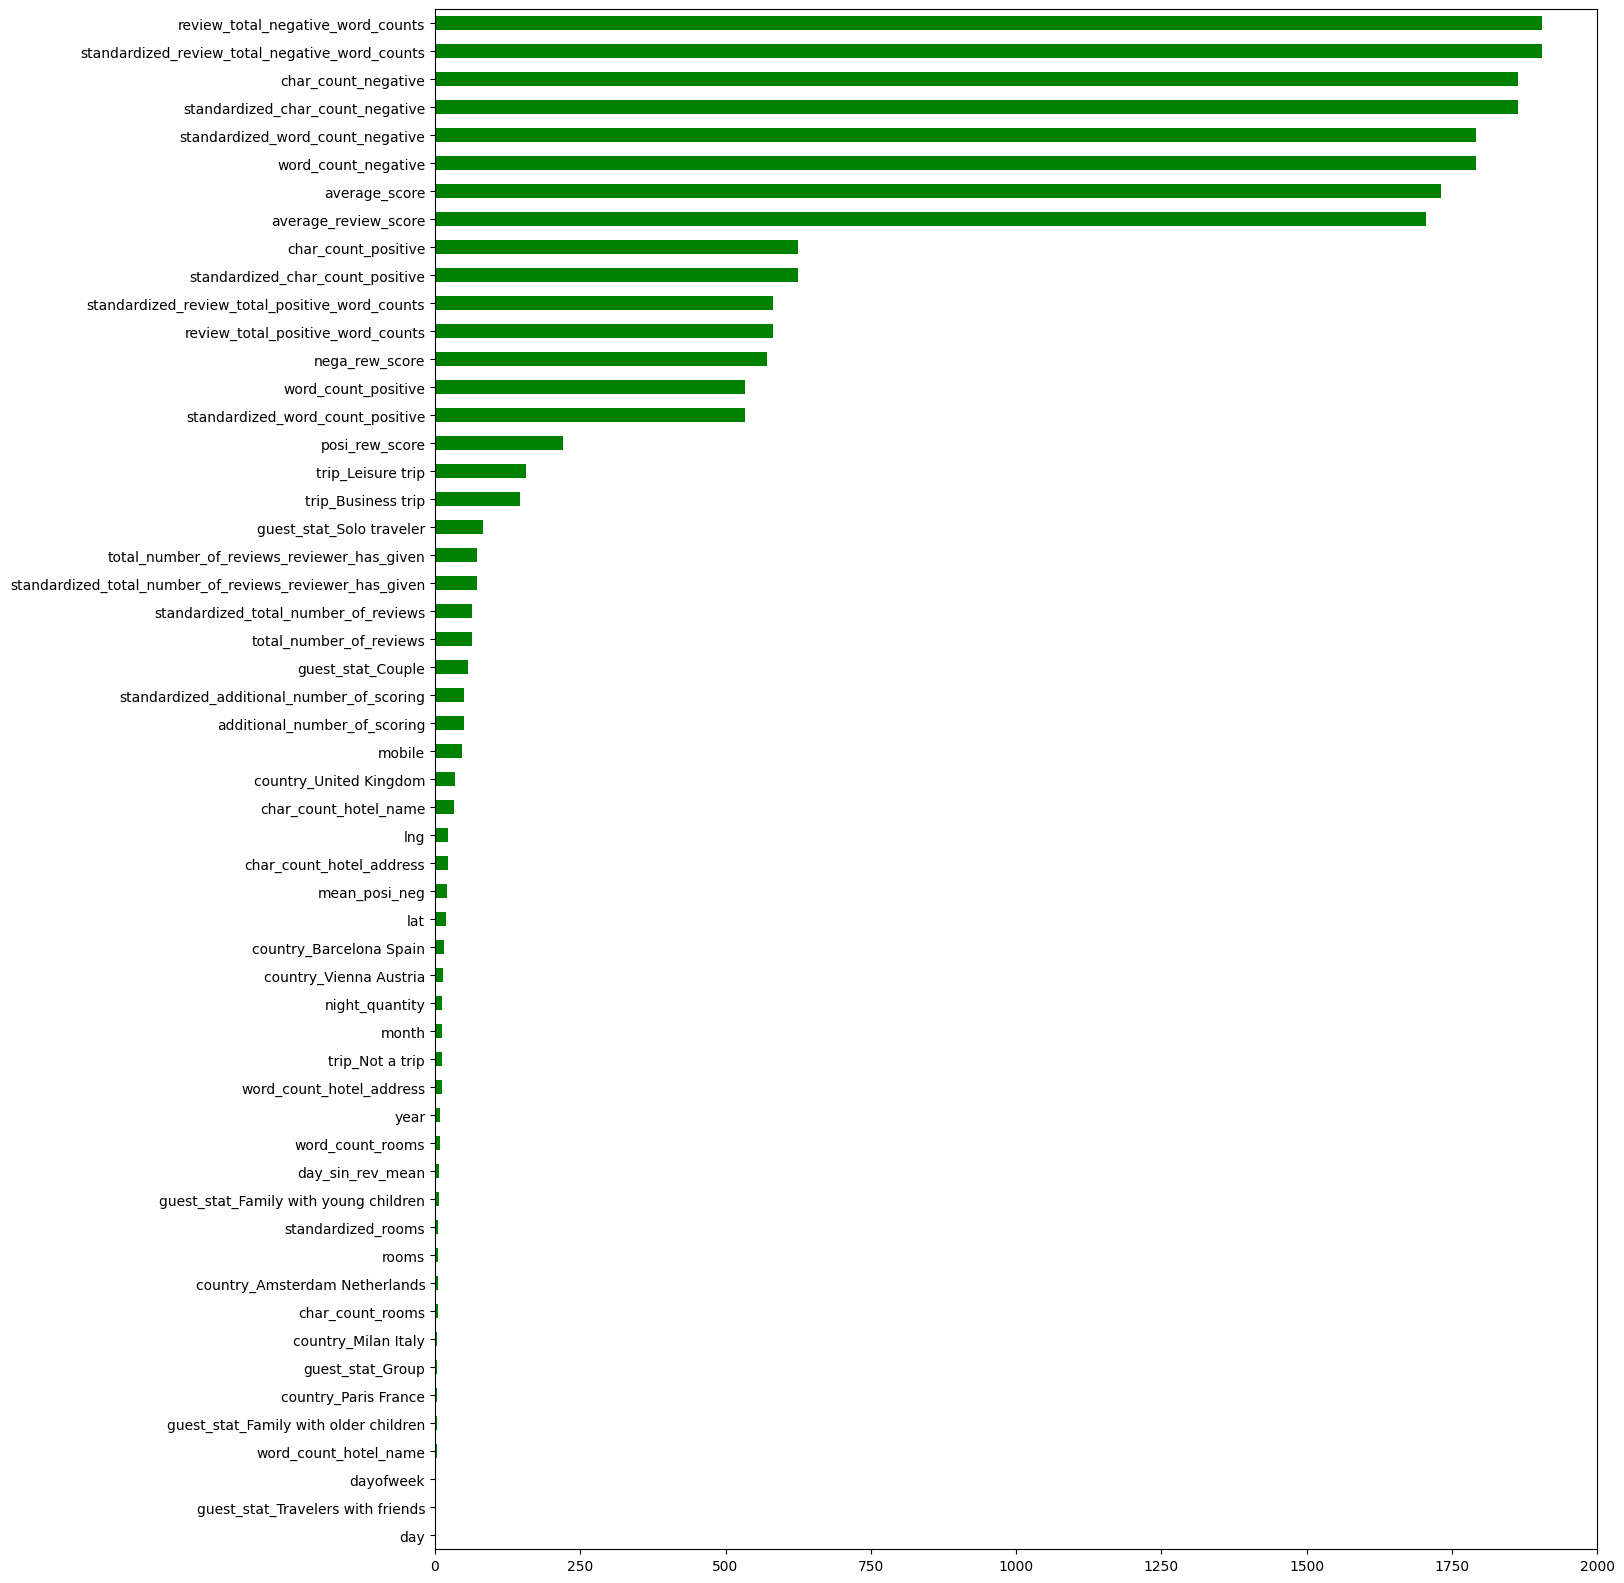

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

# Пример обработки пропущенных значений
# Заполнение пропущенных значений нулями
data.fillna(0, inplace=True)

# Выделение целевой переменной и признаков
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# Визуализация результатов анализа значимости
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index=X.columns)
imp_num.sort_values(inplace=True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind='barh', color='green');

In [108]:
# import numpy as np

# Задайте порог корреляции
threshold = 0.8

# Вычислите матрицу корреляции
corr_matrix = data.drop(['sample'], axis=1).corr()

# Создайте маску для верхнего треугольника матрицы корреляции (без диагонали)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Выберите пары признаков с корреляцией выше заданного порога
high_correlation_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j]) for i, j in zip(*np.where(np.abs(corr_matrix) > threshold)) if i < j]

# Выведите пары признаков с высокой корреляцией
print("Пары признаков с корреляцией выше", threshold, ":")
for pair in high_correlation_pairs:
    print(pair)


Пары признаков с корреляцией выше 0.8 :
('additional_number_of_scoring', 'total_number_of_reviews')
('additional_number_of_scoring', 'standardized_additional_number_of_scoring')
('additional_number_of_scoring', 'standardized_total_number_of_reviews')
('average_score', 'average_review_score')
('review_total_negative_word_counts', 'standardized_review_total_negative_word_counts')
('review_total_negative_word_counts', 'word_count_negative')
('review_total_negative_word_counts', 'char_count_negative')
('review_total_negative_word_counts', 'standardized_word_count_negative')
('review_total_negative_word_counts', 'standardized_char_count_negative')
('total_number_of_reviews', 'standardized_additional_number_of_scoring')
('total_number_of_reviews', 'standardized_total_number_of_reviews')
('review_total_positive_word_counts', 'standardized_review_total_positive_word_counts')
('review_total_positive_word_counts', 'word_count_positive')
('review_total_positive_word_counts', 'char_count_positive'

In [109]:
# data.pypsik()

In [110]:
# data = data.drop(['word_count_hotel_name','word_count_hotel_address',
#                   'trip_Business trip'], axis=1)

In [111]:

# data = data.drop('day_sin_rev_mean', axis=1)

In [112]:
# data = data.drop(['standardized_review_total_negative_word_counts',
#                   'word_count_negative','standardized_review_total_positive_word_counts',
#                   'word_count_positive'], axis=1)

In [113]:

# data = data.drop('standardized_total_number_of_reviews_reviewer_has_given', axis=1)

In [114]:


# data = data.drop(['lng','country_Vienna Austria'], axis=1)

In [115]:

# data = data.drop('review_total_positive_word_counts', axis=1)

In [116]:
# data = data.drop('total_number_of_reviews', axis=1)

In [117]:

# data = data.drop('standardized_total_number_of_reviews', axis=1)

In [118]:
# data = data.drop('review_total_negative_word_counts', axis=1)

In [119]:
# data = data.drop('additional_number_of_scoring', axis=1)

In [120]:
# data = data.drop('country_Barcelona Spain', axis=1)

In [121]:
# data = data.drop('average_score', axis=1)

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   additional_number_of_scoring                             515738 non-null  int64  
 1   average_score                                            515738 non-null  float64
 2   review_total_negative_word_counts                        515738 non-null  int64  
 3   total_number_of_reviews                                  515738 non-null  int64  
 4   review_total_positive_word_counts                        515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given               515738 non-null  int64  
 6   lat                                                      515738 non-null  float64
 7   lng                                                      515738 non-null  float64
 8   sample        

In [123]:
# data = data.drop(['guest_stat_Travelers with friends','country_Amsterdam Netherlands',
#                  'country_Milan Italy','country_United Kingdom','country_Paris France','trip_Not a trip',
#                  'guest_stat_Family with young children','guest_stat_Family with older children',
#                  'guest_stat_Group','guest_stat_Solo traveler','guest_stat_Couple','trip_Leisure trip',
#                  'mobile','year','mean_posi_neg','nega_rew_score'], axis=1)

In [124]:
# data=data.drop('word_count_rooms',axis=1)

In [125]:
# data.pypsik()

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   additional_number_of_scoring                             515738 non-null  int64  
 1   average_score                                            515738 non-null  float64
 2   review_total_negative_word_counts                        515738 non-null  int64  
 3   total_number_of_reviews                                  515738 non-null  int64  
 4   review_total_positive_word_counts                        515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given               515738 non-null  int64  
 6   lat                                                      515738 non-null  float64
 7   lng                                                      515738 non-null  float64
 8   sample        

In [127]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [128]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [129]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 56), (386803, 56), (386803, 55), (309442, 55), (77361, 55))

In [130]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [131]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   additional_number_of_scoring                             515738 non-null  int64  
 1   average_score                                            515738 non-null  float64
 2   review_total_negative_word_counts                        515738 non-null  int64  
 3   total_number_of_reviews                                  515738 non-null  int64  
 4   review_total_positive_word_counts                        515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given               515738 non-null  int64  
 6   lat                                                      515738 non-null  float64
 7   lng                                                      515738 non-null  float64
 8   sample        

In [133]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [134]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9087620506456737


<Axes: >

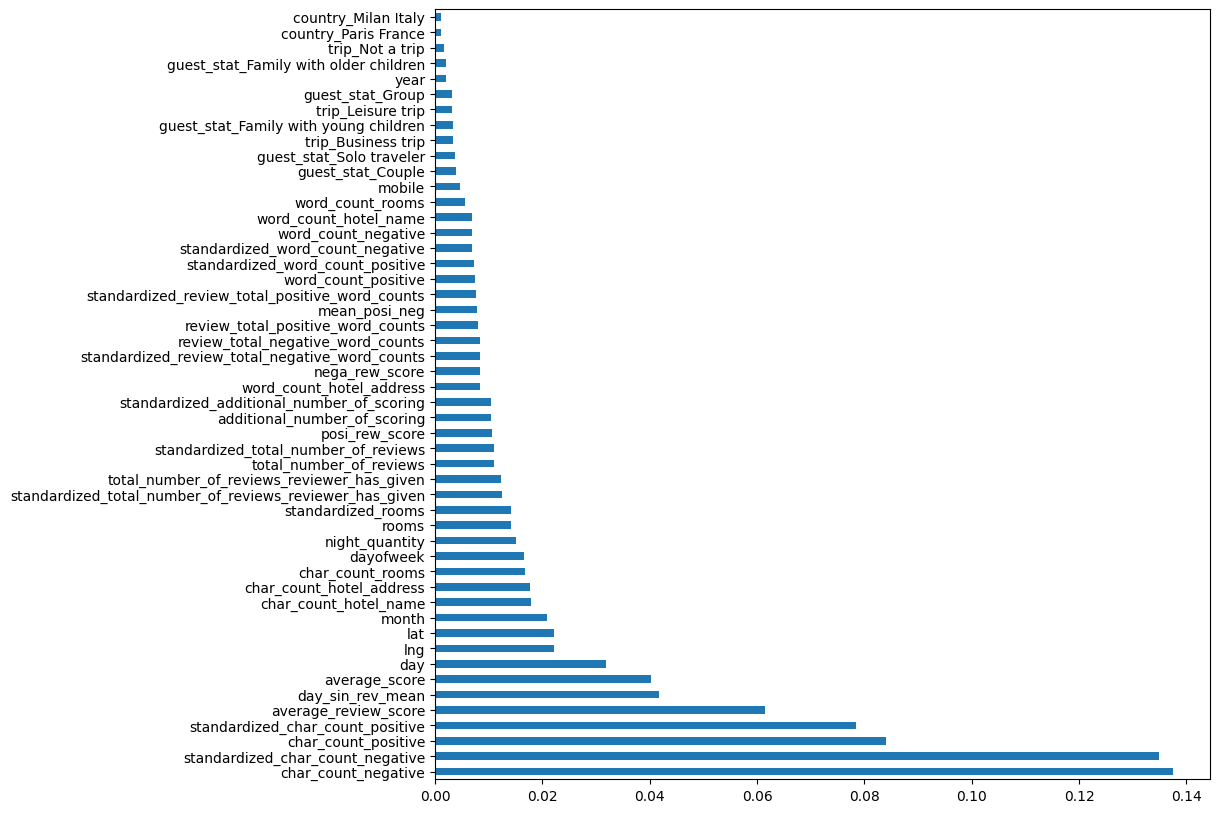

In [135]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind='barh')


In [136]:
data.pypsk()

AttributeError: 'DataFrame' object has no attribute 'pypsk'

|Name | Number|
|--|--|
Version 25 06.04.24 | MAPE: 0.9199380437171183

In [137]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,average_review_score,...,country_Vienna Austria,trip_Leisure trip,trip_Business trip,trip_Not a trip,guest_stat_Couple,guest_stat_Group,guest_stat_Solo traveler,guest_stat_Family with young children,guest_stat_Family with older children,guest_stat_Travelers with friends
115360,153,8.9,2,988,13,1,41.384969,2.177663,0.0,7.754195,...,0,1,0,0,1,0,0,0,0,0
20501,1198,8.5,14,6596,26,2,51.512974,-0.183743,0.0,7.434183,...,0,0,1,0,0,0,1,0,0,0
94487,20,8.8,3,70,7,1,51.496028,-0.168635,0.0,7.905357,...,0,0,1,0,1,0,0,0,0,0
117603,191,9.0,0,1329,12,1,48.863750,2.332041,0.0,7.890726,...,0,1,0,0,0,0,0,0,1,0
43624,498,8.6,6,3643,2,4,52.387288,4.834975,0.0,7.684463,...,0,1,0,0,1,0,0,0,0,0
114545,283,8.3,17,3287,57,18,48.162974,16.340402,0.0,7.209207,...,1,1,0,0,0,0,0,1,0,0
127315,687,8.9,5,2752,9,5,51.515052,-0.159239,0.0,7.733600,...,0,0,1,0,0,1,0,0,0,0
126685,550,8.8,11,4097,24,28,52.384606,4.894187,0.0,7.658024,...,0,1,0,0,1,0,0,0,0,0
38842,2288,8.1,0,9568,19,4,51.511099,-0.120867,0.0,7.109340,...,0,1,0,0,1,0,0,0,0,0
125759,514,8.2,26,2665,43,1,51.495369,-0.181897,0.0,7.156240,...,0,1,0,0,0,0,0,1,0,0


In [138]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [139]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [140]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.9s finished


In [141]:
predict_submission

array([8.818, 7.2  , 7.461, ..., 7.676, 9.578, 6.909])

In [142]:
list(sample_submission)

['reviewer_score', 'id']

In [143]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.818,488440
1,7.200,274649
2,7.461,374688
3,9.498,404352
4,9.522,451596
5,8.389,302161
6,8.051,317079
7,8.064,13963
8,8.849,159785
9,7.547,195089
